In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import numba

from sample_processing import *
from gibbs_sampler import *
%load_ext autoreload
%autoreload 2

/Users/tzehongti/miniforge3/envs/pymc_env_4/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Exp Logs
- Sample output 8: With 1-0.2 similarity matrix, i.e. relatively high prior information about cluster, prior on t used, randomly partition initialization used
- Sample output 9: With lambda matrix based on X. Still finds clusters. Random partition initialization used.
- Sample output 10: With 1-0.01 similarity matrix. Finds clusters well (not perfect) but very good - also lines end up much more stable
- Sample output 11: With distance based lambda. Learning is not great but not too bad also!

In [118]:
np.random.seed(0) 


In [119]:
dataset_choice = 2
col_map = ['tab:red','tab:blue','green','gold','purple','black','cyan','orange']


In [208]:
np.random.seed(1)
noise = 'norm'
n_points_per_clust = 150
Xs = np.concatenate([np.random.uniform(-1,0,n_points_per_clust),
                    np.random.uniform(0,1,n_points_per_clust)])

inds = np.array(n_points_per_clust*[0] + n_points_per_clust*[1])

betas = [np.array([-1,5]),
         np.array([0,-5])]

#betas = [np.array([1,-4]),
#         np.array([1,-4])]

if noise == 'norm':
    Ys = np.concatenate([betas[0][0] + betas[0][1]*Xs[0:n_points_per_clust] + np.random.normal(0,1,n_points_per_clust),
                     betas[1][0] + betas[1][1]*Xs[n_points_per_clust:]+ np.random.normal(0,1,n_points_per_clust)])
else: # t
    Ys = np.concatenate([betas[0][0] + betas[0][1]*Xs[0:n_points_per_clust] + np.random.standard_t(4,n_points_per_clust),
                     betas[1][0] + betas[1][1]*Xs[n_points_per_clust:]+ np.random.standard_t(4,n_points_per_clust)])


In [209]:
if dataset_choice == 3:
    betas = [np.array([-1,5]),
            np.array([-1,5]),
             np.array([-1,5]),
             np.array([-1,-8]),
             np.array([-1,-8]),
            np.array([-1,5])]

    clust_list = [1,2,2,3,3,1]

    n_points_per_clust = 70
    Xs_list = [np.random.uniform(-1,-0.75,n_points_per_clust),
                         np.random.uniform(-0.75,0,n_points_per_clust),
                         np.random.uniform(-0.75,0,n_points_per_clust),
                        np.random.uniform(0,0.75,n_points_per_clust),
                         np.random.uniform(0,0.75,n_points_per_clust),
                        np.random.uniform(0.6,1,n_points_per_clust)]

    Ys_list = []
    points_cluster_list = []
    for b_c, X_c,clust_c in zip(betas, Xs_list,clust_list):
        y_c = b_c[0] + b_c[1]*X_c + np.random.normal(0,3,n_points_per_clust)
        points_cluster_list += n_points_per_clust*[clust_c]
        Ys_list.append(y_c)

    fig, ax = plt.subplots(figsize=(8,5))

    ax.scatter(np.concatenate(Xs_list), np.concatenate(Ys_list),
               s=5,c=[col_map[i-1] for i in points_cluster_list])
    
    Ys = np.concatenate(Ys_list)
    Xs = np.concatenate(Xs_list)
    inds = points_cluster_list

In [210]:
from sklearn.model_selection import train_test_split
from scipy.stats import norm

X_train, X_test,\
    y_train, y_test,\
    inds_train, inds_test = train_test_split(Xs, Ys,
                                            inds,
                                            stratify=inds,
                                            test_size=0.25, random_state=42)


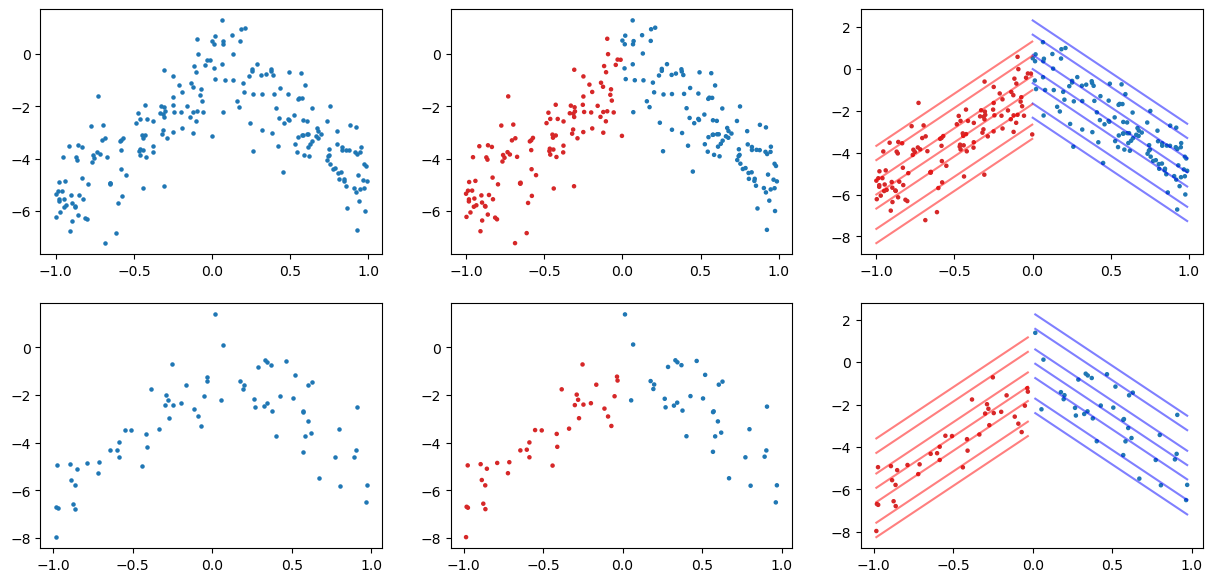

In [211]:
fig, ax = plt.subplots(2,3,figsize=(15,7))

ax[0,0].scatter(X_train,y_train, s=5)
ax[0,1].scatter(X_train,y_train,c=[col_map[i] for i in inds_train], s=5)

ax[1,0].scatter(X_test,y_test, s=5)
ax[1,1].scatter(X_test,y_test,c=[col_map[i] for i in inds_test], s=5)

col_map_true =['red','blue']
for t in [0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]:
    
    # Get implied normal quantile
    n_q = norm.ppf(t,0,1)
    
    # Get implied line
    for c in [0,1]:
        beta_c = betas[c]
        X_train_c = np.sort(X_train[inds_train==c])
        y_train_true_c = beta_c[0] + beta_c[1]*X_train_c + n_q
        
        X_test_c = np.sort(X_test[inds_test==c])
        y_test_true_c = beta_c[0] + beta_c[1]*X_test_c + n_q
    
        ax[0,2].plot(X_train_c,y_train_true_c,
                        c=col_map_true[c], alpha=0.5)
        
        ax[1,2].plot(X_test_c,y_test_true_c,
                        c=col_map_true[c], alpha=0.5)
        

ax[0,2].scatter(X_train,y_train,c=[col_map[i] for i in inds_train], s=5)
ax[1,2].scatter(X_test,y_test,c=[col_map[i] for i in inds_test], s=5)

plt.show()



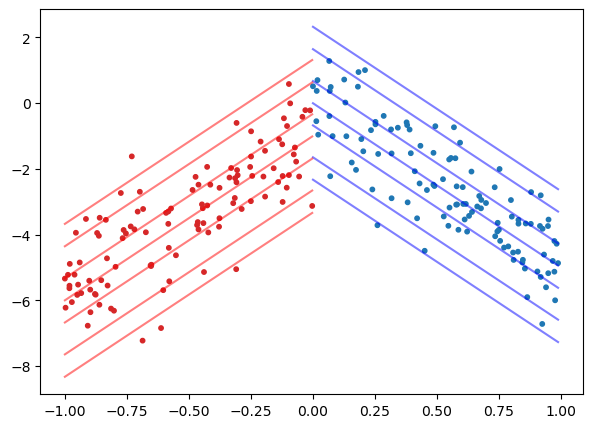

In [213]:
col_map_true =['red','blue']
fig, ax = plt.subplots(figsize=(7,5))

for t in [0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]:
    
    # Get implied normal quantile
    n_q = norm.ppf(t,0,1)
    
    # Get implied line
    for c in [0,1]:
        beta_c = betas[c]
        X_train_c = np.sort(X_train[inds_train==c])
        y_train_true_c = beta_c[0] + beta_c[1]*X_train_c + n_q
        
        ax.plot(X_train_c,y_train_true_c,
                        c=col_map_true[c], alpha=0.5)

ax.scatter(X_train,y_train,c=[col_map[i] for i in inds_train], s=10)
plt.savefig('Exp Results/Toy Eg 2/Ground Truth.png')

# First fit QR and EPA Model for Initialization

In [214]:
y_train = y_train
X_train = X_train
n_data = len(y_train)

In [215]:
len(X_train)

225

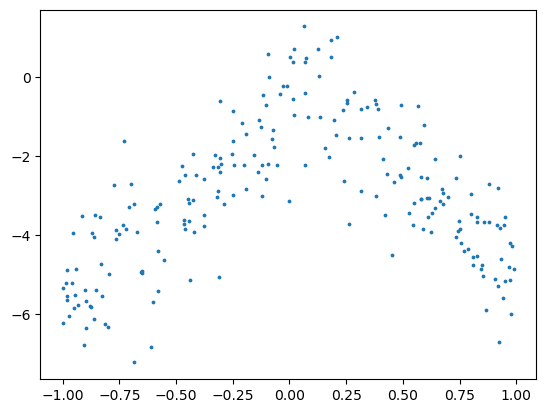

In [216]:
plt.scatter(X_train,y_train, s=3)

In [219]:
from Single_Var_QR import SingleQRSampler_T_4_block

quantile_dist = 'norm'
prior_on_t = False

# Choose no. of chains
n_chains = 2
n_steps = 20000

# Set Grid of tau values
tau_grid_expanded = np.array([round(-0.01 + 0.01 * i,2) for i in range(103)])
tau_grid = np.array([round(0.01 + 0.01 * i,2) for i in range(99)])
knot_points_grid = np.arange(0.1,1,0.1)

data_size = n_data
tau_upper_tail = 1-1/(2*data_size)
tau_lower_tail = 1/(2*data_size)
lower_seq = np.flip(geometric_seq(0.01, tau_lower_tail, 0.005, upper=False))
upper_seq = geometric_seq(0.99, tau_upper_tail, 0.005)

tau_grid = np.array([round(0.01 + 0.01 * i,2) for i in range(99)])
tau_grid = np.concatenate([lower_seq, tau_grid, upper_seq])

tau_grid_expanded = np.concatenate([np.array([-0.01,0]),
                                    tau_grid,
                                    np.array([1,1.01])])

# Run Sampler
sampler_collecter_4blockt = [SingleQRSampler_T_4_block(y_train,
                                    X_train,          
                                    C_1 = 0.3,
                                    lambda_step_size_1 = 3,
                                    alpha_step_size_1 = 0.4,
                                    a_target_1 = 0.228,
                                    C_2 = 0.3,
                                    lambda_step_size_2 = 3,
                                    alpha_step_size_2 = 0.4,
                                    a_target_2 = 0.228,
                                    C_3 = 0.5,
                                    lambda_step_size_3 = 3,
                                    alpha_step_size_3 = 0.4,
                                    a_target_3 = 0.228,
                                    C_4 = 0.3,
                                    lambda_step_size_4 = 3,
                                    alpha_step_size_4 = 0.4,
                                    a_target_4 = 0.228,
                                    tau_grid_expanded = tau_grid_expanded,
                                    tau_grid = tau_grid,     
                                    knot_points_grid = knot_points_grid,
                                    am_lamb_block1_init = (2.38**2)/(9),
                                    am_lamb_block2_init = (2.38**2)/(9),
                                    am_lamb_block3_init = (2.38**2)/4,
                                    am_lamb_block4_init = (2.38**2)/(9*2+4),
                                    alpha_kappa = 0.1,
                                    beta_kappa = 0.1,
                                    eps_1 = 0,
                                    eps_2 = 0,
                                    base_quantile_mean=0.0,
                                    base_quantile_sd=1.0,
                                    base_quantile_v=1.0,
                                    base_quantile_dist=quantile_dist,
                                    prior_on_t=prior_on_t,
                                    splice=True) for _ in range(n_chains)]

chain_outputs = [sampler_c.sample(n_steps=n_steps) for sampler_c in sampler_collecter_4blockt]

sampler_collecter = sampler_collecter_4blockt

Univariate Model
Univariate Model
Track Block:  True
Step:  0  Time Taken:  1.9837839603424072
Step:  5000  Time Taken:  42.375877141952515
Step:  10000  Time Taken:  35.91204595565796
Step:  15000  Time Taken:  38.77365803718567
Track Block:  True
Step:  0  Time Taken:  2.4040908813476562
Step:  5000  Time Taken:  31.87825107574463
Step:  10000  Time Taken:  34.22554802894592
Step:  15000  Time Taken:  33.06386184692383


Text(0.5, 0.98, 'Posterior Estimates for Various Quantile Levels')

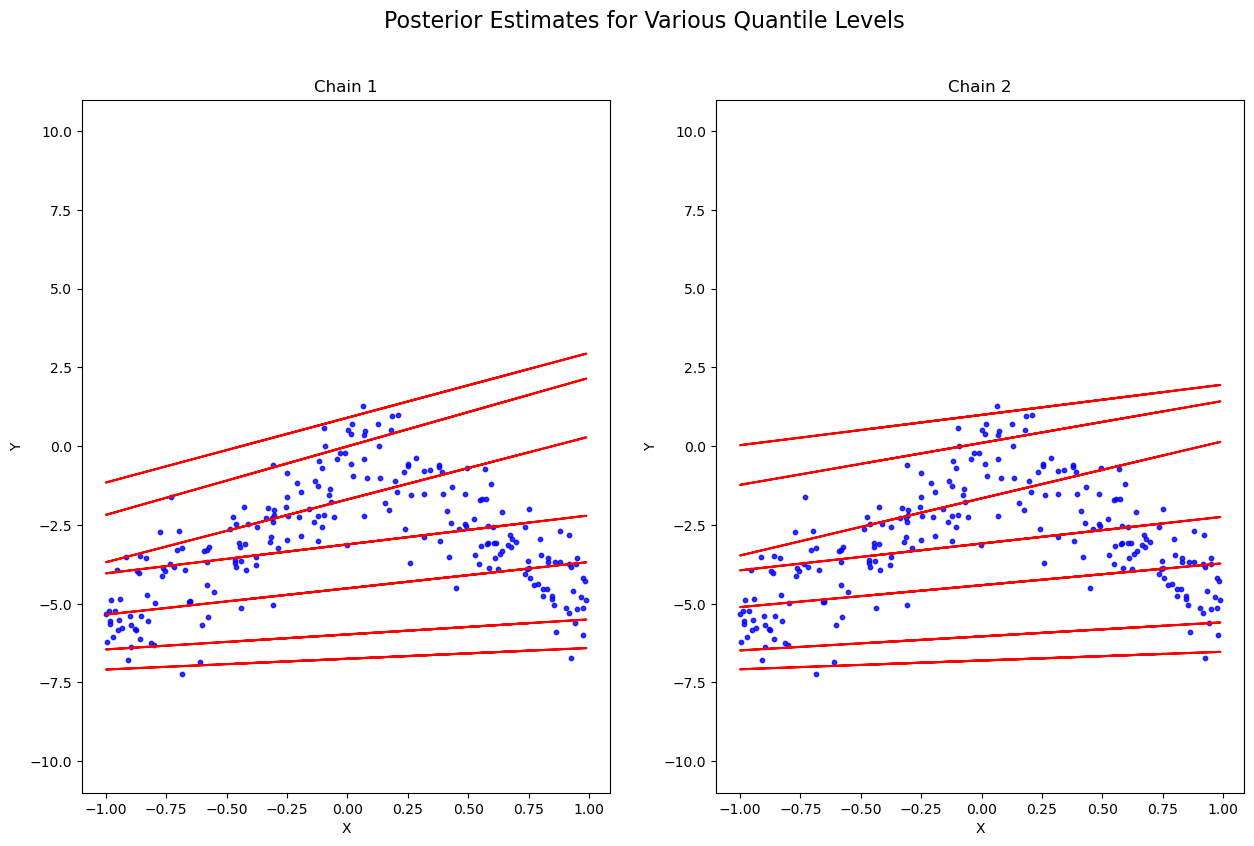

In [220]:
fig, ax = plt.subplots(1,2,figsize=(15,9))
n_burn_in = 5000

for i in range(n_chains):
    ax[i].scatter(X_train, y_train, s=10, color='blue', alpha=0.8)

sample_quantiles = [0.01,0.05, 0.25, 0.5, 0.75, 0.95,0.99]
#sample_quantiles = [0.00125,0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99,0.9975]
#sample_quantiles = [0.5]

for sq in sample_quantiles:
    
    for i in range(n_chains):
        beta_0_samps, beta_1_samps = generate_beta_samples(tau_input=sq,
                                                      tau_grid=tau_grid_expanded,
                                                      w_approx_store=chain_outputs[i]['w'],
                                                      mu_store=chain_outputs[i]['mu'],
                                                      gamma_store=chain_outputs[i]['gamma'],
                                                      sigma_1_store=chain_outputs[i]['sigma_1'],
                                                      sigma_2_store=chain_outputs[i]['sigma_2'],
                                                      base_quantile_dist=quantile_dist,
                                                          v_store=chain_outputs[i]['v'])

        y_pred_samples = np.array([b0 + b1*X_train for b0,b1 in zip(beta_0_samps, beta_1_samps)])
        y_pred_samples = y_pred_samples[n_burn_in:]
        
        ax[i].plot(X_train, y_pred_samples.mean(0), color='red')

for i in range(n_chains):    
    ax[i].title.set_text(f'Chain {i+1}')
        
ax[0].set_xlabel('X')
ax[0].set_ylabel('Y')

#ax[0].set_ylim([-4,4])
#ax[1].set_ylim([-4,4])

ax[1].set_xlabel('X')
ax[1].set_ylabel('Y')

ax[0].set_ylim([-11,11])
ax[1].set_ylim([-11,11])

fig.suptitle('Posterior Estimates for Various Quantile Levels', fontsize=16)

Get initialization parameters

In [221]:
from Single_Var_QR_utils import *
from GP_Approx import *

In [222]:
c1_params = chain_outputs[0]

In [223]:

# Get lambd and lambda grid
# Get lambda PDF
h=0.1
lambd_collect = calc_lambd_grid_uncorr(knot_points_grid.reshape(-1,1),
                                    h=h,
                                    rho_lambd_init=0.99)

lambd_grid = np.array(lambd_collect)
grid_pdf_vals = lamb_pdf(lambd_grid)
lambda_grid_log_prob = np.log(grid_pdf_vals)

#### Initialize Model Parameters
## GP Related hyperparameters
kappa_current = np.nan
rho_current = 0.1
lambd_current = 4
alpha_kappa = 3
beta_kappa = 1/3

#### W samples 
# calc covariance matrix
cov_mat_knots_current = covariance_matrix_gp_uncorr(knot_points_grid.reshape(-1,1),
                                  lambd=0)
# Precompute Matrices
cov_matrices_G, A_matrices_G = precompute_approx_uncorr(tau_grid_expanded.reshape(-1,1),
                                                   knot_points_grid.reshape(-1,1),
                                                   lambda_grid=lambd_grid)

# Initialise w1, w2 knots 
w1_knot_points_current_j = np.array(c1_params['w1_knot'][n_steps-200:n_steps-1]).mean(0)

w2_knot_points_current_j = np.array(c1_params['w2_knot'][n_steps-200:n_steps-1]).mean(0)

remain_params_j = np.array([np.array(c1_params['mu'][n_steps-200:n_steps-1]).mean(0),
                            np.array(c1_params['gamma'][n_steps-200:n_steps-1]).mean(0),
                            np.array(c1_params['sigma_1'][n_steps-200:n_steps-1]).mean(0),
                            np.array(c1_params['sigma_2'][n_steps-200:n_steps-1]).mean(0)])

mu_hat, gamma_hat, sigma1_hat, sigma2_hat = remain_params_j[0],remain_params_j[1], \
                                            (remain_params_j[2]),(remain_params_j[3])

if prior_on_t:
    v_hat = np.array(c1_params['v'][n_steps-200:n_steps-1]).mean()
else:
    v_hat=1.0
    
w1_approx_prop_j, lp_w1_j = calc_mixture_knot_approx_marginalized(w1_knot_points_current_j,
                                                                a_kappa=alpha_kappa,
                                                                b_kappa=beta_kappa,
                                                                tau_grid=tau_grid_expanded,
                                                                A_g_matrices=A_matrices_G,
                                                                cov_mat_knot_store=cov_matrices_G,
                                                                lambda_grid_log_prob=lambda_grid_log_prob)

w2_approx_prop_j, lp_w2_j = calc_mixture_knot_approx_marginalized(w2_knot_points_current_j,
                                                                a_kappa=alpha_kappa,
                                                                b_kappa=beta_kappa,
                                                                tau_grid=tau_grid_expanded,
                                                                A_g_matrices=A_matrices_G,
                                                                cov_mat_knot_store=cov_matrices_G,
                                                                lambda_grid_log_prob=lambda_grid_log_prob)


# get Eta functions
eta_1_hat  = eta_function_i_vector(tau_input=tau_grid,
                           w_vals=w1_approx_prop_j,
                           tau_grid=tau_grid_expanded,
                           mean=0.0,
                           sd=1.0,
                           v=v_hat,
                           sigma=sigma1_hat,
                           dist=quantile_dist)

eta_2_hat  = eta_function_i_vector(tau_input=tau_grid,
                       w_vals=w2_approx_prop_j,
                       tau_grid=tau_grid_expanded,
                       mean=0.0,
                       sd=1.0,
                       v=v_hat,
                       sigma=sigma2_hat,
                       dist=quantile_dist)

beta_0_hat = mu_hat + (eta_1_hat + eta_2_hat)/2
beta_1_hat = gamma_hat + (eta_2_hat - eta_1_hat)/2

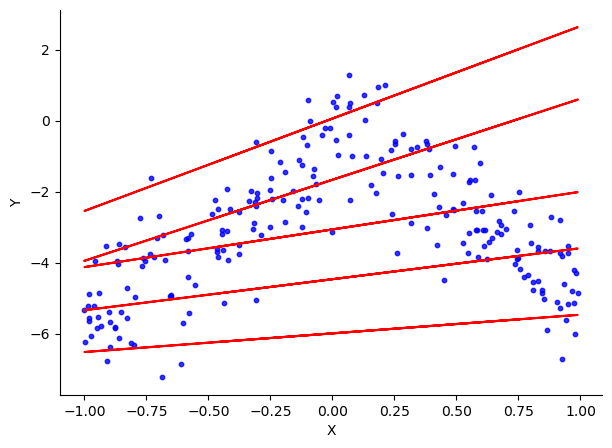

In [224]:
fig, ax = plt.subplots(figsize=(7,5))

ax.scatter(X_train, y_train, s=10, color='blue', alpha=0.8)

# Plot intialization params
sample_quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]#, 0.99,0.9975]
#sample_quantiles = [0.5]

for sq in sample_quantiles:
    
        t_id = np.searchsorted(tau_grid, sq)
        
        b0_hat = beta_0_hat[t_id]
        b1_hat = beta_1_hat[t_id]
        
        y_pred_samples = np.array(b0_hat + b1_hat*X_train)
        
        ax.plot(X_train, y_pred_samples, color='red')
        

ax.spines[['right', 'top']].set_visible(False)
ax.set_xlabel('X')
ax.set_ylabel('Y')

plt.savefig(f'Exp Results/Toy Eg 2/Single Fit.png')

plt.show()

In [225]:
 # Check if LLs are all positive
eval_ll(y_train,
                 X_train,
                 w1_approx_prop_j,
                 w2_approx_prop_j,
                 sigma1_hat,
                 sigma2_hat,
                 tau_grid,
                 tau_grid_expanded,
                 mu_hat,
                 gamma_hat,
                 base_quantile_mean=0.0,
                 base_quantile_sd=1.0,
                 base_quantile_v=v_hat,
                 base_quantile_dist=quantile_dist)

-431.39494200884053


# Model

In [226]:
from epa import *

In [227]:
Ys = y_train
Xs = X_train
Zs = X_train

#Xs = np.hstack([np.ones(len(Xs)).reshape(-1,1),Xs.reshape(-1,1)])

In [228]:
start_time = time.time()

lambda_init = 'tight' # 'standard'/'tight'

# Dist mat
tau = 2
lambda_matrix = pairwise_distances(X=Zs.reshape(-1,1), metric=exp_sim_func, tau=tau)


# intialize 
names_used = np.array([1,2])
alpha_samp = 1

# try with good distance function
partition_samp = np.array([1 if x<= 0 else 2 for x in Xs])  # Set initialization for lambda
partition_samp = inds_train.copy()

if lambda_init == 'tight':
    lambda_matrix = np.zeros((len(partition_samp), len(partition_samp)))
    # Fill in the adjacency matrix
    for i in range(len(partition_samp)):
        for j in range(len(partition_samp)):
            if partition_samp[i] == partition_samp[j]:
                lambda_matrix[i, j] = 5
            else:
                lambda_matrix[i, j] = exp_sim_func(np.array([Xs[i]]),np.array([Xs[j]]))

else:
    # Use original lambda matrix
    lambda_matrix = pairwise_distances(X=Zs.reshape(-1,1), metric=exp_sim_func, tau=tau)


# Scramble initialization after
partition_samp = np.array([1 if np.random.uniform(0,1)<0.5 else 2 for x in Xs])  # try no initialization
partition_init  = partition_samp.astype('int')

delta_samp = 0
sim_mat = lambda_matrix
order_samp = np.arange(len(Ys))
np.random.shuffle(order_samp)


#### gibbs sampling hyper parameters
n_gibbs = 2000
n_burn_in = 2000
k = 150 # no. of numbers to permute order
n_chain = 2

# GRW sampler param
rw_sd = 0.2

# alpha prior -> Want alpha to be small,  gammma prior so mean = a/b
alpha_init = 0.005
a_alpha = 1
b_alpha = 200
alpha_bounds = [0,1e99]

# delta prior -> Want delta to be smal lalso gammma prior so mean = a/b
a_delta = 1
b_delta = 100
w = 0.5
delta_bounds = [0,1]
delta_init = 0

# Tau prior
sample_tau = False
tau_bounds = [0,99]
a_tau = 4
b_tau = 2
tau_init = 1

labels_used = np.array([1,2])

reordering = True
use_split_merge_step = False


# phi sample - w1, w2, mu,gamma,sigma1,sigma2 - store as a vector

##############################
#### initialize QR Params ####
##############################
splice = True
m = 9

if not prior_on_t:
    phi_init = np.zeros([len(labels_used),
                    m+m+4])
else:
    phi_init = np.zeros([len(labels_used),
                    m+m+5])


# Set tau grid
#tau_grid_expanded = np.array([round(-0.01 + 0.01 * i,2) for i in range(103)])
#tau_grid = np.array([round(0.01 + 0.01 * i,2) for i in range(99)])
knot_points_grid = np.arange(0.1,1,0.1)
m = len(knot_points_grid)

eta1_init = np.zeros([len(labels_used),
                     len(tau_grid)])
eta2_init = np.zeros([len(labels_used),
                     len(tau_grid)])
    
# Get lambda PDF
h=0.1
lambd_collect = calc_lambd_grid_uncorr(knot_points_grid.reshape(-1,1),
                                    h=h,
                                    rho_lambd_init=0.99)
lambd_grid = np.array(lambd_collect)
grid_pdf_vals = lamb_pdf(lambd_grid)
lambda_grid_log_prob = np.log(grid_pdf_vals)

#### Initialize Model Parameters
## GP Related hyperparameters
kappa_current = np.nan
rho_current = 0.1
lambd_current = 4
alpha_kappa = 3
beta_kappa = 1/3

## Regression related parametrs
mu_current = 0
gamma_current = 0
sigma_1_current = 1
sigma_2_current = 1


#### W samples 
# calc covariance matrix
cov_mat_knots_current = covariance_matrix_gp_uncorr(knot_points_grid.reshape(-1,1),
                                  lambd=lambd_current)
# Precompute Matrices
cov_matrices_G, A_matrices_G = precompute_approx_uncorr(tau_grid_expanded.reshape(-1,1),
                                                   knot_points_grid.reshape(-1,1),
                                                   lambda_grid=lambd_grid)

for j in range(len(labels_used)):
    
    # Initialise w1, w2 knots 
    w1_knot_points_current_j = np.array(c1_params['w1_knot'][n_steps-200:n_steps-1]).mean(0)

    w2_knot_points_current_j = np.array(c1_params['w2_knot'][n_steps-200:n_steps-1]).mean(0)

    
    remain_params_j = np.array([np.array(c1_params['mu'][n_steps-200:n_steps-1]).mean(0),
                                np.array(c1_params['gamma'][n_steps-200:n_steps-1]).mean(0),
                                np.array(c1_params['sigma_1'][n_steps-200:n_steps-1]).mean(0),
                                np.array(c1_params['sigma_2'][n_steps-200:n_steps-1]).mean(0)])


    if prior_on_t:
        v_hat = np.array(c1_params['v'][n_steps-200:n_steps-1]).mean()
    else:
        v_hat=1.0
    
            
    if prior_on_t:
    # Store into phi_j
        phi_j = np.concatenate([w1_knot_points_current_j,
                                w2_knot_points_current_j,
                                remain_params_j, np.array([v_hat])])
    else:
        phi_j = np.concatenate([w1_knot_points_current_j,
                            w2_knot_points_current_j,
                            remain_params_j])

    phi_init[j] = phi_j
    
    #### Get associated Quantile Function for each phi_j ####
    w1_knot_prop = w1_knot_points_current_j
    w2_knot_prop = w2_knot_points_current_j
    # Get approx
    w1_approx_prop_j, lp_w1_j = calc_mixture_knot_approx_marginalized(w1_knot_prop,
                                                                    a_kappa=alpha_kappa,
                                                                    b_kappa=beta_kappa,
                                                                    tau_grid=tau_grid_expanded,
                                                                    A_g_matrices=A_matrices_G,
                                                                    cov_mat_knot_store=cov_matrices_G,
                                                                    lambda_grid_log_prob=lambda_grid_log_prob)
    
    w2_approx_prop_j, lp_w2_j = calc_mixture_knot_approx_marginalized(w2_knot_prop,
                                                                    a_kappa=alpha_kappa,
                                                                    b_kappa=beta_kappa,
                                                                    tau_grid=tau_grid_expanded,
                                                                    A_g_matrices=A_matrices_G,
                                                                    cov_mat_knot_store=cov_matrices_G,
                                                                    lambda_grid_log_prob=lambda_grid_log_prob)
    # Get Q function
    mu_j, gamma_j, sigma1_j, sigma2_j = phi_j[18],phi_j[19],phi_j[20],phi_j[21]

    # get Eta functions
    eta_1_j  = eta_function_i_vector(tau_input=tau_grid,
                               w_vals=w1_approx_prop_j,
                               tau_grid=tau_grid_expanded,
                               mean=0.0,
                               sd=1.0,
                               v=v_hat,
                               sigma=sigma1_j,
                               dist=quantile_dist)

    eta_2_j  = eta_function_i_vector(tau_input=tau_grid,
                           w_vals=w2_approx_prop_j,
                           tau_grid=tau_grid_expanded,
                           mean=0.0,
                           sd=1.0,
                           v=v_hat,
                           sigma=sigma2_j,
                           dist=quantile_dist)

    eta1_init[j] = eta_1_j
    eta2_init[j] = eta_2_j

In [229]:
Ys = Ys
Xs = Xs
Zs = Zs
sim_mat = sim_mat
partition_init = partition_init
phi_init = phi_init

tau_init =   tau_init
labels_used = labels_used
alpha_init = alpha_init
delta_init = delta_init
n_gibbs = n_gibbs
n_burn_in = n_burn_in
k = k
a_alpha = a_alpha
b_alpha = b_alpha
a_delta = a_delta
b_delta = b_delta
a_tau =  a_tau
b_tau =  b_tau
w = 0.5
reordering = reordering
use_split_merge_step = use_split_merge_step
sample_tau = False

In [ ]:
n = len(Ys)
# intialize 
names_used = labels_used
alpha_samp = alpha_init

delta_samp = delta_init
order_samp = np.arange(n)
np.random.shuffle(order_samp)

# initialize QR params
phi_samp = phi_init
eta1_samp = eta1_init
eta2_samp = eta2_init

partition_samp = partition_init
tau_samp = tau_init


#### gibbs sampling hyper parameters
n_gibbs = n_gibbs
k = k # no. of numbers to permute order

# GRW sampler param
rw_sd = 0.2

# alpha prior
a_alpha = a_alpha
b_alpha = b_alpha
alpha_bounds = [0,1e99]

# delta prior
a_delta = a_delta
b_delta = b_delta

assert (w<=1) and (w>=0)
w = w
delta_bounds = [0,1]
tau_bounds = [0,1e99]


partition_save = []
alpha_save = []
delta_save = []
phi_save = []
log_prob_save = []
sigma_reg_save = []
tau_save = []

# Track acceptance rates
split_merge_accept_save = []
tau_accept_save = []
delta_accept_save = []
order_accept_save = []
alpha_accept_save = []


s1 = time.time()
# Gibbs loop
for g in range(n_gibbs+n_burn_in):
    if g%100 == 0:
        e1 = time.time()
        print("Gibbs: ", g, " Time Taken: ", (e1-s1)/60)
        print("Active No Clusters: ", len(np.unique(partition_samp)))
        print("Active No Clusters: ", pd.Series(partition_samp).value_counts())
        s1 = time.time()

    # Get last term in order samp
    #last_term_samp = order_samp[-1]
    last_term_id = order_samp[-1]#np.where(order_samp == np.max(order_samp))[0][0]

    #print('Partition Update')
    # Draw sample for the final term
    if prior_on_t:
        v_samp = phi_samp[-1]
    else:
        v_samp = 1.0
    
    partition_samp, phi_samp, names_used, \
        partition_factors, eta1_samp, eta2_samp = sample_conditional_i_clust_gibbs_opti_parallel_QR(
                                    i=last_term_id,
                                    order_place=0,
                                    partition=partition_samp,
                                    return_fac=True,
                                    pre_compute_factors=np.zeros(1),
                                    alpha=alpha_samp,
                                    delta=delta_samp,
                                    sim_mat=sim_mat,
                                    order=order_samp,
                                    phi=phi_samp,
                                    eta1_mat=eta1_samp, 
                                    eta2_mat=eta2_samp,
                                    y=Ys,
                                    x=Xs,
                                    A_matrices_G = A_matrices_G,
                                    cov_matrices_G = cov_matrices_G,
                                    lambda_grid_log_prob= lambda_grid_log_prob,
                                       w_cov_mat=cov_mat_knots_current,
                                      alpha_kappa=5,
                                      beta_kappa=1/3,
                                      tau_grid=tau_grid,
                                      tau_grid_expanded=tau_grid_expanded,
                                    base_quantile_mean=0.0,
                                     base_quantile_sd=1.0,
                                     base_quantile_v=v_samp,
                                     base_quantile_dist=quantile_dist,
                                    names_used=names_used,                      
                                    reordering=reordering,
                                    splice=splice,
                                    prior_on_t=prior_on_t)
    
    for o in list(range(len(order_samp)-2,-1,-1)):

        term_id = order_samp[o]#np.where(order_samp == o)[0][0]

        partition_samp, phi_samp, names_used,\
              eta1_samp, eta2_samp= sample_conditional_i_clust_gibbs_opti_parallel_QR(
                                        i=term_id,
                                        order_place=o,
                                        partition=partition_samp,
                                        return_fac=False,
                                        pre_compute_factors=partition_factors,
                                        alpha=alpha_samp,
                                        delta=delta_samp,
                                        sim_mat=sim_mat,
                                        order=order_samp,
                                        phi=phi_samp,
                                        eta1_mat=eta1_samp, 
                                        eta2_mat=eta2_samp,
                                        y=Ys,
                                        x=Xs,
                                        A_matrices_G = A_matrices_G,
                                    cov_matrices_G = cov_matrices_G,
                                    lambda_grid_log_prob= lambda_grid_log_prob,
                                    
                                           w_cov_mat=cov_mat_knots_current,
                                          alpha_kappa=5,
                                          beta_kappa=1/3,
                                          tau_grid=tau_grid,
                                          tau_grid_expanded=tau_grid_expanded,
                                        base_quantile_mean=0.0,
                                         base_quantile_sd=1.0,
                                         base_quantile_v=v_samp,
                                         base_quantile_dist=quantile_dist,
                                        names_used=names_used,
                                        reordering=reordering,
                                            prior_on_t=prior_on_t)

    """
    if use_split_merge_step:
    #### Split Merge step ####
        partition_samp,phi_samp, names_used,\
        sigma2_reg_samp, accept_samp = split_merge_step(partition_samp=partition_samp,
                                                    alpha=alpha_samp,
                                                    delta=delta_samp,
                                                    sim_mat=sim_mat,
                                                    order=order_samp,
                                                    phi_samp=phi_samp,
                                                    y=Ys,
                                                    x=Xs, 
                                                    sigma2_reg_samp=sigma2_reg_samp,
                                                    v_0=v_0,
                                                    sigma2_0=sigma2_0,
                                                    names_used=names_used, 
                                                    phi_base_mean=phi_mean_prior,
                                                    phi_base_cov=phi_cov_prior,
                                                    no_intermediate_steps=5)

        if g>n_burn_in:

            split_merge_accept_save.append(accept_samp)
    """

    partition_samp = partition_samp.astype('int')

    if g%10 == 0:
        1+1
        #print('QR Update - Step: ', g)
        #print("Current No. Cluster: ", np.max(partition_samp))
        # Update phis
    
    
    phi_samp, eta1_samp, eta2_samp = sample_phi_QR(phi_cur=phi_samp,
                           eta1_cur=eta1_samp,
                           eta2_cur=eta2_samp,
                           n_steps=200,
                           y=Ys,
                           x=Xs,
                            A_matrices_G = A_matrices_G,
                        cov_matrices_G = cov_matrices_G,
                        lambda_grid_log_prob= lambda_grid_log_prob,
                        cov_mat_knots_init=cov_mat_knots_current,
                           partition=partition_samp,
                          tau_grid=tau_grid,
                           tau_grid_expanded=tau_grid_expanded,
                           base_quantile_mean=0.0,
                           base_quantile_sd=1.0,
                           base_quantile_v=1.0,
                          base_quantile_dist=quantile_dist,
                          prior_on_t=prior_on_t)

    # Sample ordering 
    #order_samp = permute_k(order_samp, k)
    order_samp,order_accept_s = metropolis_step_order(order_current=order_samp,
                                    alpha=alpha_samp,
                                    delta=delta_samp,
                                    partition=partition_samp,
                                    sim_mat=sim_mat,
                                    k=k)

    if g>n_burn_in:
        order_accept_save.append(order_accept_s)

    #### Sample parameters, alpha, sigma

    alpha_samp, alpha_accept_s = metropolis_step_alpha(alpha_samp,
                                                    rw_sd,
                                                    a_alpha, b_alpha,
                                                    partition_samp,
                                                        delta_samp,
                                                        sim_mat,
                                                        order_samp,
                                                    bounds=alpha_bounds)

    if g>n_burn_in:

        alpha_accept_save.append(alpha_accept_s)

    delta_samp, delta_accept_s = metropolis_step_delta(delta_samp, rw_sd,
                                                    a_delta, b_delta, w,
                                                    partition_samp,
                                                        alpha_samp,
                                                        sim_mat,
                                                        order_samp,bounds=delta_bounds)

    if g>n_burn_in:

        delta_accept_save.append(delta_accept_s)

    # Update Tau + Sim mat
    if sample_tau:
        tau_samp, sim_mat, tau_accept_s = metropolis_step_tau(tau_samp, rw_sd, a_tau, b_tau,
                            partition_samp,
                                alpha_samp,
                                delta_samp,
                                sim_mat,
                                X=Zs.reshape(-1,1),
                        order=order_samp,bounds=tau_bounds)

        if g>n_burn_in:
            tau_accept_save.append(tau_accept_s)

    """
    # Calc log prob of result
    log_prob_samp = calc_log_joint(partition=partition_samp,
                                phi=phi_samp,
                                y=Ys,
                                x=Xs,
                                sim_mat=sim_mat,
                                order=order_samp,
                                alpha=alpha_samp,
                                delta=delta_samp,
                                sigma_reg = sigma_reg)
    """

    if g>n_burn_in:

        # Save sampled values
        #log_prob_save.append(log_prob_samp)
        partition_save.append(partition_samp)
        alpha_save.append(alpha_samp)
        delta_save.append(delta_samp)
        phi_save.append(phi_samp)
        tau_save.append(tau_samp)


acceptance_rates = {'Split Merge': np.mean(split_merge_accept_save),
                    'Tau': np.mean(tau_accept_save),
                    'Delta': np.mean(delta_accept_save),
                    'Order': np.mean(order_accept_save),
                    'Alpha': np.mean(alpha_accept_save)}

acceptance_rates = pd.DataFrame.from_dict(acceptance_rates, orient='index')
acceptance_rates.columns=['Acceptance Rate']
acceptance_rates

        

Gibbs:  0  Time Taken:  6.198883056640625e-06
Active No Clusters:  2
Active No Clusters:  1    117
2    108
dtype: int64
Gibbs:  100  Time Taken:  8.448232154051462
Active No Clusters:  2
Active No Clusters:  1    114
2    111
dtype: int64
Gibbs:  200  Time Taken:  8.340863303343456
Active No Clusters:  2
Active No Clusters:  1    115
2    110
dtype: int64
Gibbs:  300  Time Taken:  7.556128100554148
Active No Clusters:  2
Active No Clusters:  1    116
2    109
dtype: int64
Gibbs:  400  Time Taken:  8.53604234457016
Active No Clusters:  2
Active No Clusters:  1    113
2    112
dtype: int64
Gibbs:  500  Time Taken:  7.462678853670756
Active No Clusters:  2
Active No Clusters:  1    113
2    112
dtype: int64
Gibbs:  600  Time Taken:  6.932236746946971
Active No Clusters:  2
Active No Clusters:  1    115
2    110
dtype: int64
Gibbs:  700  Time Taken:  8.36163886388143
Active No Clusters:  2
Active No Clusters:  1    113
2    112
dtype: int64


In [ ]:
import pickle
save = False
if save:
    with open('Exp Results/Sample Output 2/partition_save.pickle', 'wb') as file:
        pickle.dump(partition_save, file)
    with open('Exp Results/Sample Output 2/phi_save.pickle', 'wb') as file:
        pickle.dump(phi_save, file)

Get Co-Clustering Matrix

In [ ]:
cluster_size_samples = np.array([len(np.unique(p)) for p in partition_save])
np.mean(cluster_size_samples)

In [ ]:

normalized_sim_mat = calc_hit_matrix(partition_save,
                                     burn_samples=0,
                                     normalize=True)

plt.matshow(normalized_sim_mat)
plt.show()

In [ ]:
color_list =['black','blue','green']


In [ ]:
agglo_cluster_solution = agglo_cluster(sim_matrix=normalized_sim_mat,
                                       n_clust=2,
                                       linkage_type='complete')

fig, ax = plt.subplots(figsize=(7,5))


ax.scatter(X_train, y_train,
            s=10, color=[color_list[i] for i in agglo_cluster_solution], alpha=0.8)

ax.spines[['right', 'top']].set_visible(False)
ax.set_xlabel('X')
ax.set_ylabel('Y')

#plt.savefig(f'Exp Results/Toy Eg 1/Cluster_Plot.png')

plt.show()


In [189]:
len(agglo_cluster_solution)

375

In [190]:
def calc_c_vals(cluster_sol, similarity_mat):
    
    c_vals = np.zeros(len(cluster_sol))
    for i in range(len(cluster_sol)):

        point_clust = cluster_sol[i]
        point_sims = similarity_mat[i]

        neighbs = np.where(cluster_sol==point_clust)[0]
        neighbs_sim = point_sims[neighbs]
        c_val_i = np.mean(neighbs_sim)
        c_vals[i] = c_val_i
        
        return c_vals
    
def confidence_matrix(cluster_sol, similarity_mat):
    
    # Get names of clusters
    sorted_clust_names = pd.Series(cluster_sol).value_counts().index

    # Re-arrange IDs and form new sorted similarity matrix
    arranged_ids = []
    for c in sorted_clust_names:

        clust_ids = np.where(cluster_sol==c)[0]
        c_vals_clust = c_vals[clust_ids]
        sorted_clust_ids =clust_ids[np.argsort(c_vals_clust)[::-1]]

        arranged_ids.append(sorted_clust_ids)

    arranged_ids = np.concatenate(arranged_ids)

    sorted_matrix = np.zeros((len(cluster_sol),len(cluster_sol)))

    for i in range(len(cluster_sol)):
        for j in range(len(cluster_sol)):

            sorted_matrix[i,j] = sim_mat[arranged_ids[i], arranged_ids[j]]

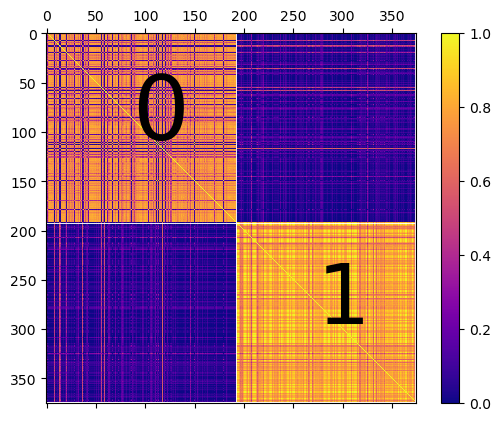

In [191]:
# Calculate c-vals
c_vals = calc_c_vals(agglo_cluster_solution, normalized_sim_mat)

sorted_clust_names = pd.Series(agglo_cluster_solution).value_counts().index

arranged_ids = []
for c in sorted_clust_names:

    clust_ids = np.where(agglo_cluster_solution==c)[0]
    c_vals_clust = c_vals[clust_ids]
    sorted_clust_ids =clust_ids[np.argsort(c_vals_clust)[::-1]]
    
    arranged_ids.append(sorted_clust_ids)
    
arranged_ids = np.concatenate(arranged_ids)

sorted_matrix = np.zeros((len(Ys),len(Ys)))

for i in range(len(Ys)):
    for j in range(len(Ys)):
        
        sorted_matrix[i,j] = normalized_sim_mat[arranged_ids[i], arranged_ids[j]]

figure = plt.figure()
axes = figure.add_subplot(111)

caxes = axes.matshow(sorted_matrix, cmap='plasma')
figure.colorbar(caxes)

clust_sizes = pd.Series(agglo_cluster_solution).value_counts().values

for clust_size,clust_name, n in zip(clust_sizes,sorted_clust_names,clust_sizes.cumsum()):
    
    axes.axvline(n-1,c='white',lw=0.65)
    axes.axhline(n-1,c='white',lw=0.65)

    axes.text(n-clust_size//2-10, n-clust_size//2+10, str(clust_name), color="k", fontsize=clust_size/3)

#plt.savefig('Exp Results/Toy Eg 1/mixture_QR_conf_plot.png')
plt.show()


Get posterior predictive quantiles


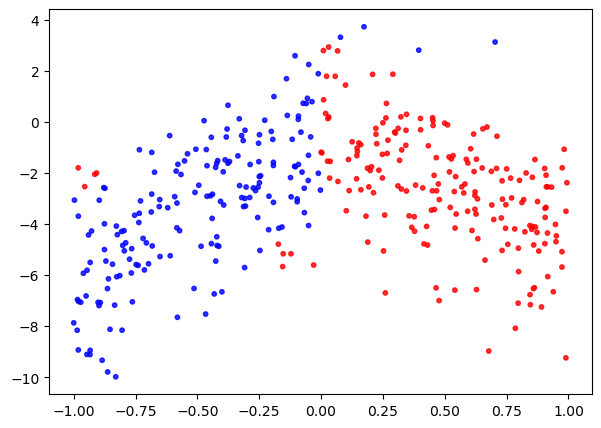

In [192]:
agglo_cluster_solution = agglo_cluster(sim_matrix=normalized_sim_mat,
                                       n_clust=2,
                                       linkage_type='complete')

fig, ax = plt.subplots(figsize=(7,5))

color_list = ['red','blue',
            'green','yellow','black','purple','brown']

ax.scatter(X_train, y_train,
            s=10, color=[color_list[i] for i in agglo_cluster_solution], alpha=0.8)

#plt.savefig('Exp Results/Tog Eg 1/mixture_QR_clusters.png')


In [193]:
Q_sample_collect = []
x_vals_checker = []
omitted_samps = 0
omitted_samp_id = []
omitted_samp_out = []
#bad_samps1 = np.where(np.min(np.min(Q_sample_collect,1),1)<-30)[0]
#bad_samps2 = np.where(np.min(np.min(Q_sample_collect,1),1)>30)[0]


for i in range(n_gibbs-1):#range(n_gibbs-1): # range(n_gibbs-1):
    
    #if (i in bad_samps1) or (i in bad_samps2):
     #   continue
    
    # Get cluster
    partition_samp = partition_save[i]

    # Get phi samp
    phi_samp = phi_save[i]

    output_q_tx = []
    x_vals_arr = []
    # Iterate through each cluster
    for k in np.unique(partition_samp):

        # Extract data points + phi_k
        phi_k = phi_samp[k-1]

        point_ids = np.where(partition_samp==k)[0]

        # Extract X Values
        x_vals_k = X_train[point_ids]

        # Using phi generate the quantile regression function
        phi_samp_clust = phi_samp[k-1,:]
        m = (len(phi_samp_clust) - 4)// 2
        w1_knot_points_current = phi_samp_clust[0:m]
        w2_knot_points_current = phi_samp_clust[m:2*m]
        mu_current = phi_samp_clust[2*m]
        gamma_current = phi_samp_clust[2*m+1]
        #sigma_1_current = np.exp(phi_samp_clust[2*m+2])
        #sigma_2_current = np.exp(phi_samp_clust[2*m+3])
        sigma_1_current = phi_samp_clust[2*m+2]
        sigma_2_current = phi_samp_clust[2*m+3]
        
        if prior_on_t:
            v_current = phi_samp_clust[2*m+4]
        else:
            v_current = 1.0
        # Generate quantities
        
        # Generate sample of GP approx
        w1_approx_current, lp_w1_current = calc_mixture_knot_approx_marginalized(w1_knot_points_current,
                                                                                a_kappa=alpha_kappa,
                                                                                b_kappa=beta_kappa,
                                                                                tau_grid=tau_grid_expanded,
                                                                                A_g_matrices=A_matrices_G,
                                                                                cov_mat_knot_store=cov_matrices_G,
                                                                                lambda_grid_log_prob=lambda_grid_log_prob)

        w2_approx_current, lp_w2_current = calc_mixture_knot_approx_marginalized(w2_knot_points_current,
                                                                                a_kappa=alpha_kappa,
                                                                                b_kappa=beta_kappa,
                                                                                tau_grid=tau_grid_expanded,
                                                                                A_g_matrices=A_matrices_G,
                                                                                cov_mat_knot_store=cov_matrices_G,
                                                                                lambda_grid_log_prob=lambda_grid_log_prob)
        
        # Generate Q
        eta_1  = eta_function_i_vector(tau_input=tau_grid,
                            w_vals=w1_approx_current,
                            tau_grid=tau_grid_expanded,
                            mean=0.0,
                            sd=1.0,
                            v=v_current,
                            sigma=sigma_1_current,
                            dist=quantile_dist)

        eta_2  = eta_function_i_vector(tau_input=tau_grid,
                            w_vals=w2_approx_current,
                            tau_grid=tau_grid_expanded,
                            mean=0.0,
                            sd=1.0,
                            v=v_current,
                            sigma=sigma_2_current,
                            dist=quantile_dist)
        
        Q_tx  = mu_current + gamma_current * np.expand_dims(x_vals_k, -1) + \
            np.expand_dims((1-x_vals_k)/2, -1) * eta_1 + \
            np.expand_dims((1+x_vals_k)/2, -1) * eta_2
        
        beta_0_samp = mu_current + (eta_1 + eta_2)/2
        beta_1_samp = gamma_current + (eta_1 - eta_2)/2
        
        Q_tx_alt = np.array([b0 + b1*x_vals_k for b0,b1 in zip(beta_0_samp, beta_1_samp)])
        
        output_q_tx.append(Q_tx_alt.T)
        x_vals_arr.append(x_vals_k)

    output_q_tx = np.concatenate(output_q_tx,0)
    x_vals_arr = np.concatenate(x_vals_arr,0)
    
    sort_ids = np.argsort(x_vals_arr)
    x_vals_arr = x_vals_arr[sort_ids]
    output_q_tx = output_q_tx[sort_ids,:]
    
    # Optional
    if (np.max(output_q_tx) > 1e9) or (np.min(output_q_tx)<-1e9):
        omitted_samps += 1
        omitted_samp_id.append(i)
        omitted_samp_out.append(output_q_tx)
        #continue
    
    Q_sample_collect.append(output_q_tx)
    x_vals_checker.append(x_vals_arr)

Q_sample_collect = [Q.reshape(1,len(X_train),len(tau_grid)) for Q in Q_sample_collect]
Q_sample_collect = np.concatenate(Q_sample_collect,0)

In [194]:
omitted_samp_id

[]

In [195]:
quantile_means = np.mean(Q_sample_collect,0)
#quantile_means = Q_sample_collect[1500]
#quantile_means.shape

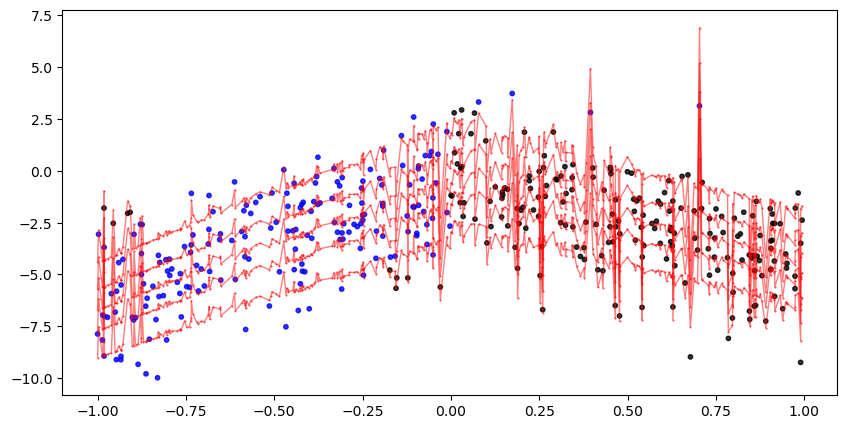

In [196]:

# Extract some arrays
wanted_taus = [0.05, 0.25, 0.5,0.75, 0.95]
tau_ids = np.array([np.where(tau_grid==w_t)[0][0] for w_t in wanted_taus])

plot_qtx = quantile_means[:, tau_ids]


fig, ax = plt.subplots(figsize=(10,5))

color_list =['black','blue','green']

ax.scatter(X_train, y_train,
            s=10, color=[color_list[i] for i in agglo_cluster_solution], alpha=0.8)

ax.plot(x_vals_arr, plot_qtx,alpha=0.5,lw=1, c='red',marker='*',ms=1)

#plt.savefig('Exp Results/Toy Eg 1/mixture_QR_quantile_lines.png')
plt.show()


In [197]:
import arviz as az

/var/folders/0p/10_vdl_n673_r_lydsdd278m0000gn/T/ipykernel_56592/2492987449.py:13: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  Q_cis = az.hdi(plot_qtx)


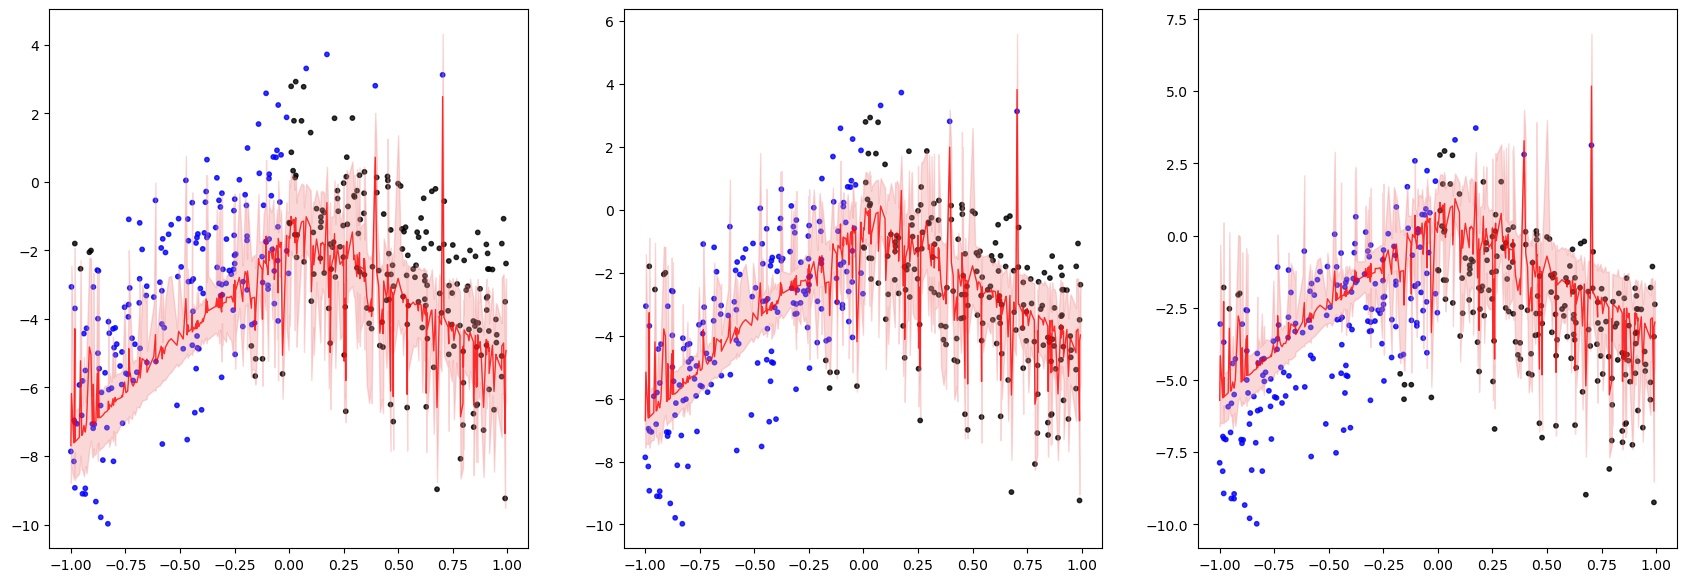

In [198]:
# Extract some arrays
fig, ax = plt.subplots(1,3,figsize=(21,7))
wanted_tau_cands = [0.25, 0.5, 0.75]

for i, wanted_tau in enumerate(wanted_tau_cands):

    tau_ids = np.array([np.where(tau_grid==w_t)[0][0] for w_t in [wanted_tau]])

    plot_qtx = Q_sample_collect[:,:, tau_ids].squeeze()

    # Get mean
    mean_Q = plot_qtx.mean(0)
    Q_cis = az.hdi(plot_qtx)

    color_list =['black','blue','green']

    ax[i].scatter(X_train, y_train,
                s=10, color=[color_list[i] for i in agglo_cluster_solution], alpha=0.8)

    ax[i].plot(x_vals_arr, mean_Q,alpha=0.8,lw=1, c='red')
    ax[i].fill_between(x_vals_arr, Q_cis[:,0],
                            Q_cis[:,1], color='lightcoral', alpha=.3)


/var/folders/0p/10_vdl_n673_r_lydsdd278m0000gn/T/ipykernel_56592/3122924417.py:14: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  Q_cis = az.hdi(plot_qtx)


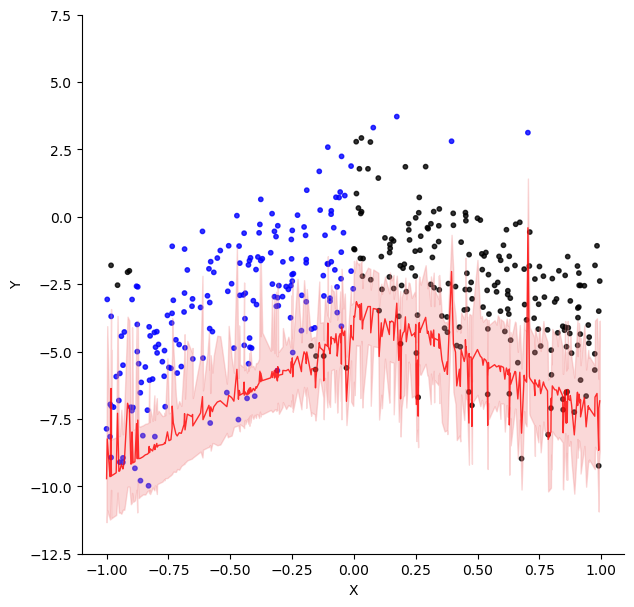

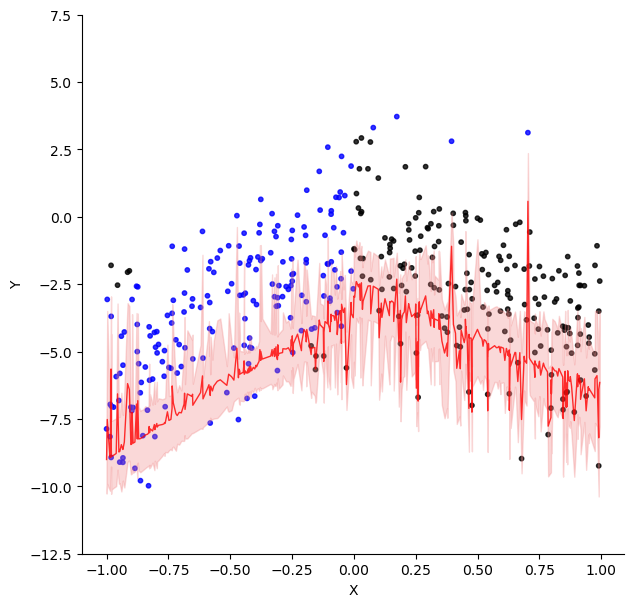

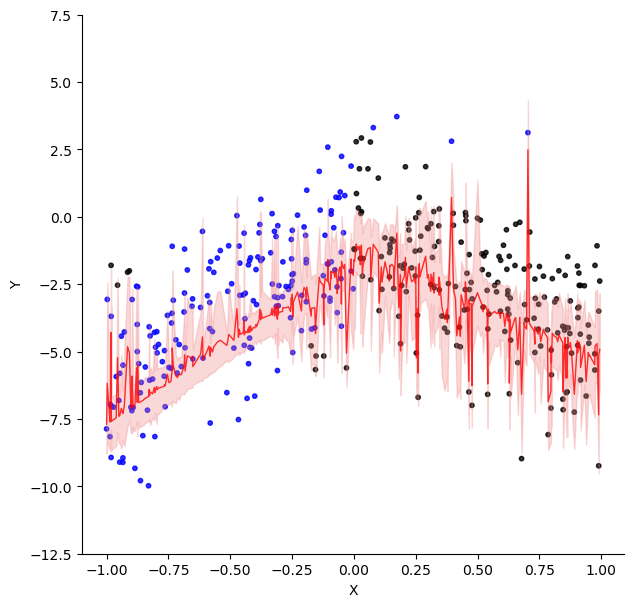

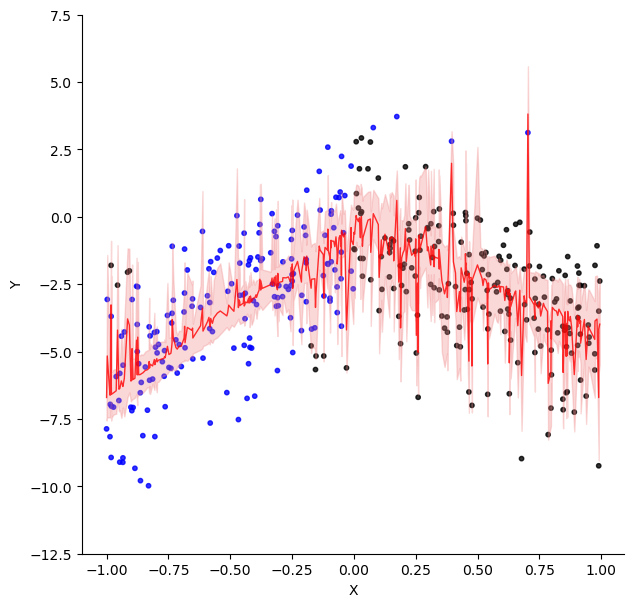

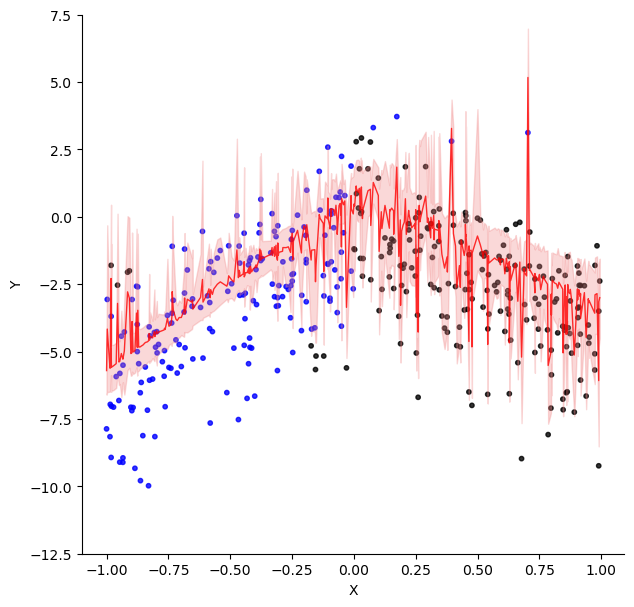

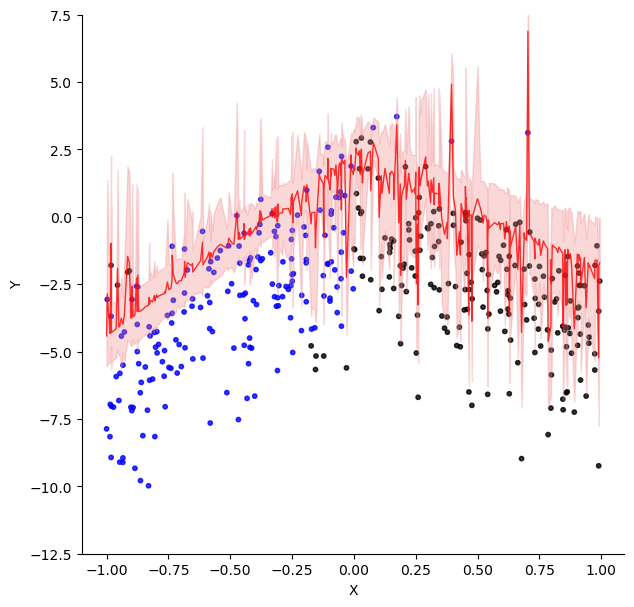

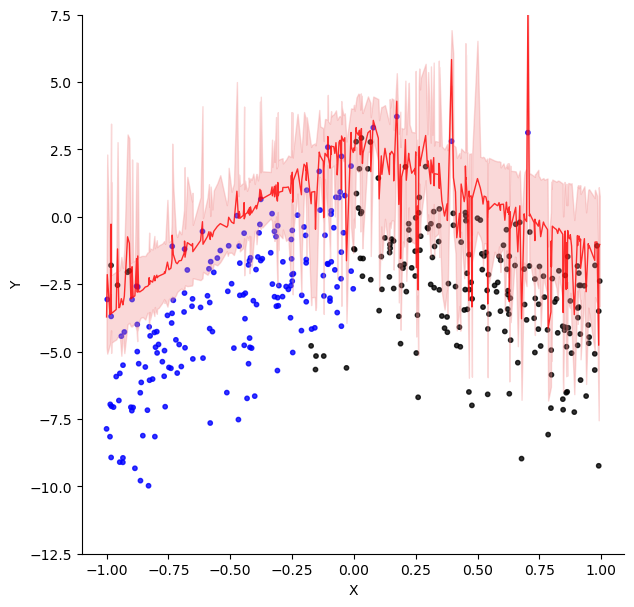

In [199]:
# Same plot but 1 by 1 for saving
wanted_tau_cands = [0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]

for i, wanted_tau in enumerate(wanted_tau_cands):

    fig, ax = plt.subplots(figsize=(7,7))

    tau_ids = np.array([np.where(tau_grid==w_t)[0][0] for w_t in [wanted_tau]])

    plot_qtx = Q_sample_collect[:,:, tau_ids].squeeze()

    # Get mean
    mean_Q = plot_qtx.mean(0)
    Q_cis = az.hdi(plot_qtx)

    color_list =['black','blue','green']

    ax.scatter(X_train, y_train,
                s=10, color=[color_list[i] for i in agglo_cluster_solution], alpha=0.8)

    ax.plot(x_vals_arr, mean_Q,alpha=0.8,lw=1, c='red')
    ax.fill_between(x_vals_arr, Q_cis[:,0],
                            Q_cis[:,1], color='lightcoral', alpha=.3)
    
    ax.set_ylim([-12.5, 7.5])
    ax.spines[['right', 'top']].set_visible(False)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')

    #plt.savefig(f'Exp Results/Toy Eg 1/mixture_QR_quantile_line_{wanted_tau}.png')
    
    

## Anchor Points analysis

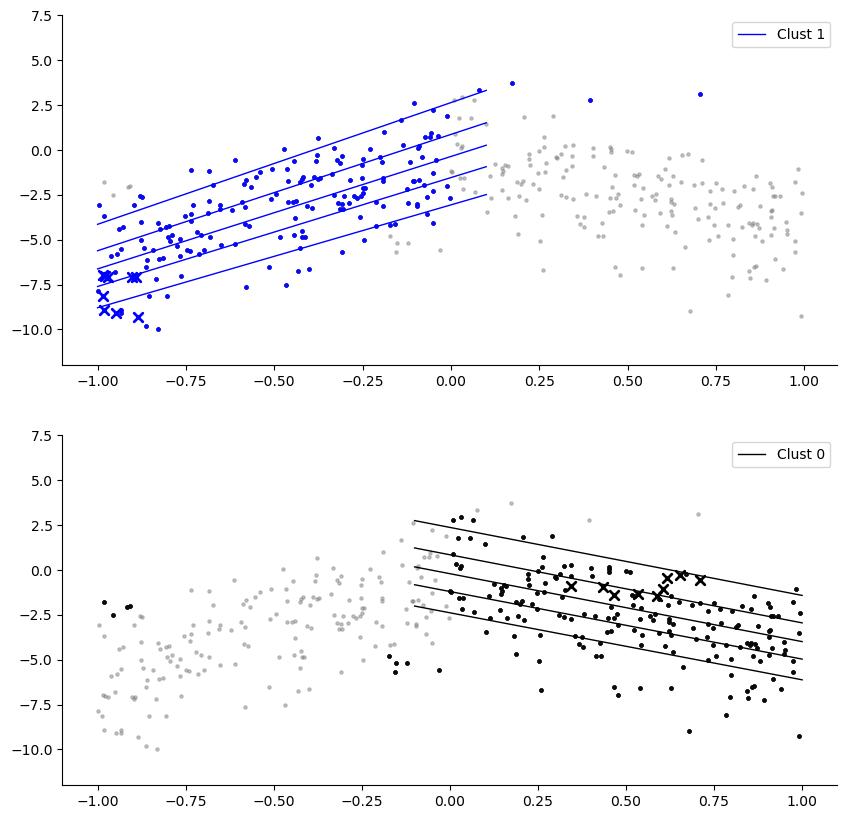

In [202]:

# Extract points in clusters
cluster_ids = pd.Series(agglo_cluster_solution).unique()

fig, ax = plt.subplots(len(cluster_ids), 1, figsize=(10,5*len(cluster_ids)))


for c_id in cluster_ids:
    
    # Extract points in that cluster
    cluster_member_id = np.where(agglo_cluster_solution==c_id)[0]
    points_sim = normalized_sim_mat[np.ix_(cluster_member_id, cluster_member_id)]

    # Choose k and get top k point
    k = int(len(cluster_member_id)*0.05)
    point_wise_scores = np.sum(points_sim, 1)
    sorted_indices_desc = np.argsort(np.array(point_wise_scores))[::-1][0:k]

    cluster_exemplar_ids = cluster_member_id[sorted_indices_desc]


    beta_0_save = []
    beta_1_save = []

    beta_weight = []

    for phi_samp, partition_samp in zip(phi_save,partition_save):

        exemplar_partitions = partition_samp[cluster_exemplar_ids]
        for k in np.unique(exemplar_partitions):

            # Get count
            p_count = np.sum(exemplar_partitions==k)

            # Extract phi
            phi_k = phi_samp[k-1]


            # Using phi generate the quantile regression function
            phi_samp_clust = phi_samp[k-1,:]
            m = (len(phi_samp_clust) - 4)// 2
            w1_knot_points_current = phi_samp_clust[0:m]
            w2_knot_points_current = phi_samp_clust[m:2*m]
            mu_current = phi_samp_clust[2*m]
            gamma_current = phi_samp_clust[2*m+1]
            #sigma_1_current = np.exp(phi_samp_clust[2*m+2])
            #sigma_2_current = np.exp(phi_samp_clust[2*m+3])
            sigma_1_current = phi_samp_clust[2*m+2]
            sigma_2_current = phi_samp_clust[2*m+3]
            # Generate quantities

            if prior_on_t:
                v_current = phi_samp_clust[2*m+4]

            else:
                v_current = 1.0

            # Generate sample of GP approx
            w1_approx_current, lp_w1_current = calc_mixture_knot_approx_marginalized(w1_knot_points_current,
                                                                                    a_kappa=alpha_kappa,
                                                                                    b_kappa=beta_kappa,
                                                                                    tau_grid=tau_grid_expanded,
                                                                                    A_g_matrices=A_matrices_G,
                                                                                    cov_mat_knot_store=cov_matrices_G,
                                                                                    lambda_grid_log_prob=lambda_grid_log_prob)

            w2_approx_current, lp_w2_current = calc_mixture_knot_approx_marginalized(w2_knot_points_current,
                                                                                    a_kappa=alpha_kappa,
                                                                                    b_kappa=beta_kappa,
                                                                                    tau_grid=tau_grid_expanded,
                                                                                    A_g_matrices=A_matrices_G,
                                                                                    cov_mat_knot_store=cov_matrices_G,
                                                                                    lambda_grid_log_prob=lambda_grid_log_prob)

            # Generate Q
            eta_1  = eta_function_i_vector(tau_input=tau_grid,
                                w_vals=w1_approx_current,
                                tau_grid=tau_grid_expanded,
                                mean=0.0,
                                sd=1.0,
                                v=v_current,
                                sigma=sigma_1_current,
                                dist=quantile_dist)

            eta_2  = eta_function_i_vector(tau_input=tau_grid,
                                w_vals=w2_approx_current,
                                tau_grid=tau_grid_expanded,
                                mean=0.0,
                                sd=1.0,
                                v=v_current,
                                sigma=sigma_2_current,
                                dist=quantile_dist)

            # Get beta samp
            beta_0_samp = mu_current + (eta_1 + eta_2)/2
            beta_1_samp = gamma_current + (eta_1 - eta_2)/2

            beta_0_save.append(beta_0_samp)
            beta_1_save.append(beta_1_samp)

            beta_weight.append(p_count)
    
    #x_grid = np.linspace(np.min(Xs), np.max(Xs),10)
    if c_id == 0:
        x_grid = np.linspace(-0.1, 1,10)
    else:
        x_grid = np.linspace(-1, 0.1,10)

    beta_0_expanded = np.vstack([b0 for b0, count in zip(beta_0_save, beta_weight) for _ in range(count)])
    beta_1_expanded = np.vstack([b1 for b1, count in zip(beta_1_save, beta_weight) for _ in range(count)])

    sample_quantiles = [0.05,0.25,0.5,0.75,0.95]
    sample_quantile_inds = [np.argwhere(tau_grid_expanded==q)[0][0] for q in sample_quantiles]

    
    
    for h, sample_quantile_id in enumerate(sample_quantile_inds):


        b0_samples = beta_0_expanded[:,sample_quantile_id]
        b1_samples = beta_1_expanded[:,sample_quantile_id]
        
        # Remove possible outliers
        b0_samples = b0_samples[np.abs(b0_samples)<1e5]
        b1_samples = b1_samples[np.abs(b1_samples)<1e5]
        
        b0_mean = b0_samples.mean()
        b1_mean = b1_samples.mean()
        y_vals = b0_mean + b1_mean * x_grid

        # Plot exemplar
        ax[c_id-1].scatter(Xs, Ys, c='gray',alpha=0.1, s=5)
        ax[c_id-1].set_ylim([-12,7.5])
        ax[c_id-1].spines[['right', 'top']].set_visible(False)

        xs_cluster = Xs[cluster_member_id]
        ys_cluster = Ys[cluster_member_id]

        xs_cluster_exemplar = Xs[cluster_exemplar_ids]
        ys_cluster_exemplar = Ys[cluster_exemplar_ids]
        ax[c_id-1].scatter(xs_cluster, ys_cluster, c=color_list[c_id],alpha=0.5, s=5)
        ax[c_id-1].scatter(xs_cluster_exemplar, ys_cluster_exemplar, c=color_list[c_id],alpha=1,
                   s=50, marker='x')
        
        if h == len(sample_quantile_inds)-1:
            ax[c_id-1].plot(x_grid, y_vals, c=color_list[c_id],alpha=1, lw=1,
                           label=f'Clust {c_id}')
        else:
            ax[c_id-1].plot(x_grid, y_vals, c=color_list[c_id],alpha=1, lw=1)

    ax[c_id-1].legend()
        
    col_map_true =['red','blue']
    
    """
    for t in [0.05, 0.25, 0.5, 0.75, 0.95]:

        # Get implied normal quantile
        n_q = norm.ppf(t,0,2)

        # Get implied line
        for c in [0,1]:
            beta_c = betas[c]
            X_train_c = np.sort(X_train[inds_train==c])
            y_train_true_c = beta_c[0] + beta_c[1]*X_train_c + n_q

            ax[c_id-1].plot(X_train_c,y_train_true_c,
                            c=col_map_true[c], alpha=0.5)
    """
            
#plt.savefig(f'Exp Results/Toy Eg 1/Exemplar_Reg.png')
plt.show()

/var/folders/0p/10_vdl_n673_r_lydsdd278m0000gn/T/ipykernel_56592/8057979.py:125: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  b0_CIs = az.hdi(beta_0_expanded)
/var/folders/0p/10_vdl_n673_r_lydsdd278m0000gn/T/ipykernel_56592/8057979.py:126: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  b1_CIs = az.hdi(beta_1_expanded)


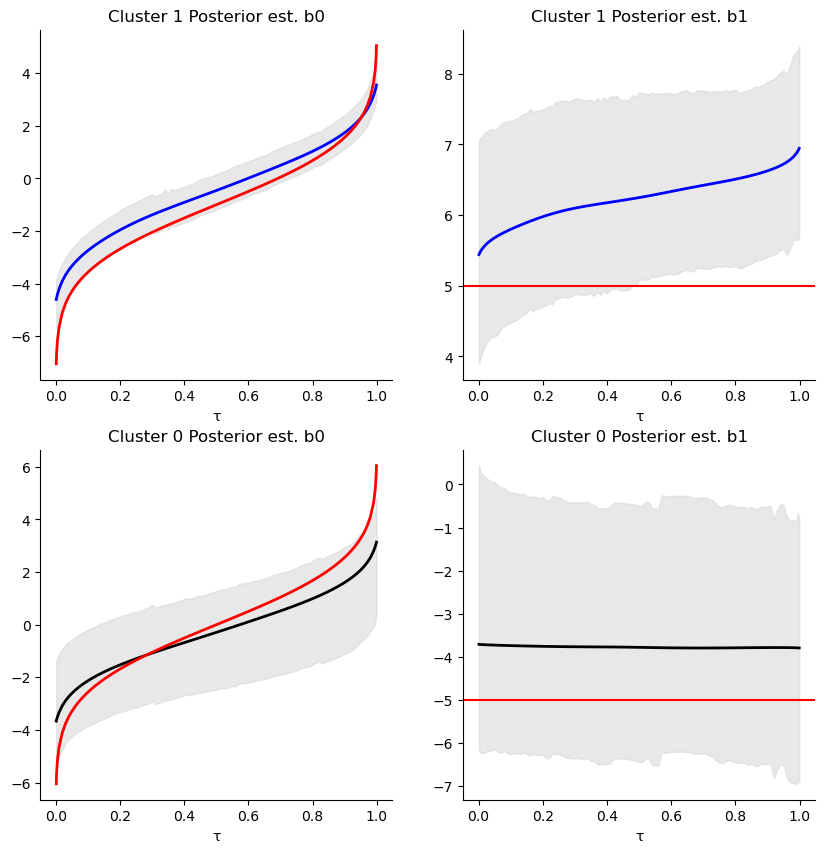

In [203]:
# Extract points in clusters
cluster_ids = pd.Series(agglo_cluster_solution).unique()

fig, ax = plt.subplots(len(cluster_ids), 2, figsize=(10,5*len(cluster_ids)))


for c_id in cluster_ids:
    
    # Extract points in that cluster
    cluster_member_id = np.where(agglo_cluster_solution==c_id)[0]
    points_sim = normalized_sim_mat[np.ix_(cluster_member_id, cluster_member_id)]

    # Choose k and get top k point
    k = int(len(cluster_member_id)*0.05)
    point_wise_scores = np.sum(points_sim, 1)
    sorted_indices_desc = np.argsort(np.array(point_wise_scores))[::-1][0:k]

    cluster_exemplar_ids = cluster_member_id[sorted_indices_desc]


    beta_0_save = []
    beta_1_save = []

    beta_weight = []

    for phi_samp, partition_samp in zip(phi_save,partition_save):

        exemplar_partitions = partition_samp[cluster_exemplar_ids]
        for k in np.unique(exemplar_partitions):

            # Get count
            p_count = np.sum(exemplar_partitions==k)

            # Extract phi
            phi_k = phi_samp[k-1]


            # Using phi generate the quantile regression function
            phi_samp_clust = phi_samp[k-1,:]
            m = (len(phi_samp_clust) - 4)// 2
            w1_knot_points_current = phi_samp_clust[0:m]
            w2_knot_points_current = phi_samp_clust[m:2*m]
            mu_current = phi_samp_clust[2*m]
            gamma_current = phi_samp_clust[2*m+1]
            #sigma_1_current = np.exp(phi_samp_clust[2*m+2])
            #sigma_2_current = np.exp(phi_samp_clust[2*m+3])
            sigma_1_current = phi_samp_clust[2*m+2]
            sigma_2_current = phi_samp_clust[2*m+3]
            # Generate quantities

            if prior_on_t:
                v_current = phi_samp_clust[2*m+4]

            else:
                v_current = 1.0

            # Generate sample of GP approx
            w1_approx_current, lp_w1_current = calc_mixture_knot_approx_marginalized(w1_knot_points_current,
                                                                                    a_kappa=alpha_kappa,
                                                                                    b_kappa=beta_kappa,
                                                                                    tau_grid=tau_grid_expanded,
                                                                                    A_g_matrices=A_matrices_G,
                                                                                    cov_mat_knot_store=cov_matrices_G,
                                                                                    lambda_grid_log_prob=lambda_grid_log_prob)

            w2_approx_current, lp_w2_current = calc_mixture_knot_approx_marginalized(w2_knot_points_current,
                                                                                    a_kappa=alpha_kappa,
                                                                                    b_kappa=beta_kappa,
                                                                                    tau_grid=tau_grid_expanded,
                                                                                    A_g_matrices=A_matrices_G,
                                                                                    cov_mat_knot_store=cov_matrices_G,
                                                                                    lambda_grid_log_prob=lambda_grid_log_prob)

            # Generate Q
            eta_1  = eta_function_i_vector(tau_input=tau_grid,
                                w_vals=w1_approx_current,
                                tau_grid=tau_grid_expanded,
                                mean=0.0,
                                sd=1.0,
                                v=v_current,
                                sigma=sigma_1_current,
                                dist=quantile_dist)

            eta_2  = eta_function_i_vector(tau_input=tau_grid,
                                w_vals=w2_approx_current,
                                tau_grid=tau_grid_expanded,
                                mean=0.0,
                                sd=1.0,
                                v=v_current,
                                sigma=sigma_2_current,
                                dist=quantile_dist)

            # Get beta samp
            beta_0_samp = mu_current + (eta_1 + eta_2)/2
            beta_1_samp = gamma_current + (eta_1 - eta_2)/2

            beta_0_save.append(beta_0_samp)
            beta_1_save.append(beta_1_samp)

            beta_weight.append(p_count)
    
    #x_grid = np.linspace(np.min(Xs), np.max(Xs),10)
    if c_id == 1:
        x_grid = np.linspace(-0.1, 1,10)
    else:
        x_grid = np.linspace(-1, 0.1,10)

    beta_0_expanded = np.vstack([b0 for b0, count in zip(beta_0_save, beta_weight) for _ in range(count)])
    beta_1_expanded = np.vstack([b1 for b1, count in zip(beta_1_save, beta_weight) for _ in range(count)])

    sample_quantiles = [0.05,0.25,0.5,0.75,0.95]
    sample_quantile_inds = [np.argwhere(tau_grid_expanded==q)[0][0] for q in sample_quantiles]


    b0_samples = beta_0_expanded
    b1_samples = beta_1_expanded

    # Remove possible outliers
    b0_samples = b0_samples[np.abs(b0_samples)<1e5]
    b1_samples = b1_samples[np.abs(b1_samples)<1e5]

    b0_mean = beta_0_expanded.mean(0)
    b1_mean = beta_1_expanded.mean(0)
    
    b0_CIs = az.hdi(beta_0_expanded)
    b1_CIs = az.hdi(beta_1_expanded)
    
    # Plot values
    ax[c_id-1,0].plot(tau_grid, b0_mean, color=color_list[c_id],lw=2)
    ax[c_id-1,0].fill_between(tau_grid, b0_CIs[:,0],
                    b0_CIs[:,1], color='lightgray', alpha=.5)
    
    ax[c_id-1,1].plot(tau_grid, b1_mean, color=color_list[c_id],lw=2)
    ax[c_id-1,1].fill_between(tau_grid, b1_CIs[:,0],
                    b1_CIs[:,1], color='lightgray', alpha=.5)

    ax[c_id-1,0].title.set_text(f"Cluster {c_id} Posterior est. b0")
    ax[c_id-1,1].title.set_text(f"Cluster {c_id} Posterior est. b1")

    
    ax[c_id-1,0].set_xlabel('τ')
    ax[c_id-1,1].set_xlabel('τ')
    
    ax[c_id-1,0].spines[['right', 'top']].set_visible(False)
    ax[c_id-1,1].spines[['right', 'top']].set_visible(False)

    # Plot true
    if c_id == 0:
        ax[c_id-1,0].plot(tau_grid,
                          norm.ppf(tau_grid,0,2)+0, color='red',lw=2)
        
        ax[c_id-1,1].axhline(-5, color='red')
    else:
        ax[c_id-1,0].plot(tau_grid,
                          norm.ppf(tau_grid,0,2)-1, color='red',lw=2)
        
        ax[c_id-1,1].axhline(5, color='red')
        

    
   # ax[c_id-1].axhline(y=0,linestyle='--', c = 'black')

    #max_val = np.max(b1_c_cis[:,1])
    #min_val = np.min(b1_c_cis[:,0])

    #ax[c_id-1].set_ylim([min_val-1,max_val+1])

    #ax[c_id-1].spines[['right', 'top']].set_visible(False)
            
#plt.savefig(f'Exp Results/Toy Eg 1/Exemplar_slope.png')
plt.show()

## Posterior Predictive

In [124]:
@numba.njit 
def exp_sim_func(x1:float, x2:float, tau:float=1) -> float:
    """ Exponential similarity function

    Args:
        x1 (float): first input
        x2 (float): second input

    Returns:
        float: exponential similarity between x1 and x2
    """    
    return np.exp(-tau*np.linalg.norm(x1-x2)**2)

#### Functions for predictive probability distribution ####
def calc_predictive_partition_dist(partition,
                                   sim_vec,
                                   alpha,
                                   delta):
    
    q = len(np.unique(partition))
    t = len(partition) + 1

    clust_cands = np.unique(partition)
    total_sim = np.sum(sim_vec)
    prob_col = []
    for c in clust_cands:

        # Extract members 
        partition_members = np.where(partition==c)[0]

        clust_sim = np.sum(sim_vec[partition_members])

        partition_comp = (((t-1 - delta * q)/(alpha + t-1)) * (clust_sim/total_sim))

        prob_col.append(partition_comp)
    # Calc new cluster
    partition_comp_new = (alpha+delta*q)/(alpha+t-1)
    prob_col.insert(0, partition_comp_new)
    prob_col = np.array(prob_col)
    
    if prob_col.sum() != 1:
        
        if np.abs(prob_col.sum()-1) > 1e-2:
            print('Warning Sum Probs: ', np.sum(prob_col))
            print(partition)
            print(sim_vec)
            print(alpha)
            print(delta)
        
        else:
            prob_col = prob_col/prob_col.sum()
        
    clust_cands = np.concatenate([np.zeros(1),clust_cands])
    return prob_col, clust_cands


def calc_predictive_partition_dist_matrix(partition,
                                   sim_mat,
                                   alpha,
                                   delta):

    n_input_points = sim_mat.shape[0]

    q = len(np.unique(partition))
    t = len(partition) + 1

    clust_cands = np.unique(partition)
    total_sim = np.sum(sim_mat,1)
    prob_col = []

    for c in clust_cands:

        partition_members = np.where(partition==c)[0]
        clust_sim = np.sum(sim_mat[:,partition_members],1)
        partition_comp = (((t-1 - delta * q)/(alpha + t-1)) * (clust_sim/total_sim))

        prob_col.append(partition_comp)

    # Calc new cluster
    partition_comp_new = n_input_points * [(alpha+delta*q)/(alpha+t-1)]
    partition_comp_new = np.array(partition_comp_new)

    prob_col.insert(0, partition_comp_new)
    prob_assignment_mat = np.vstack(prob_col).T
    clust_cands = np.concatenate([np.zeros(1),clust_cands])
    
    return prob_assignment_mat, clust_cands
    
def sample_posterior_predictive(Xs_input,
                                mcmc_chain,
                                Zs_in,
                                Zs_fit,
                               phi_base_mean,
                               phi_base_cov,
                               v_0,
                               sigma2_0):
    
    n_chains = len(mcmc_chain)
    
    sampled_predictive = np.zeros([n_chains, len(mcmc_chain[0][5])])

    for nc in range(n_chains):
        
        phi_save = mcmc_chain[nc][5]
        partition_save = mcmc_chain[nc][1]
        delta_save = mcmc_chain[nc][3]
        alpha_save = mcmc_chain[nc][2]
        tau_save = mcmc_chain[nc][4]
        sigma_save = mcmc_chain[nc][6]
        

        sampled_predictive_chain = np.zeros(len(phi_save))

        for g in range(len(phi_save)):


            phi_g = phi_save[g]
            sigma_g = sigma_save[g]
            partition_g = partition_save[g]

            alpha_g = alpha_save[g]
            delta_g = delta_save[g]

            tau_g = tau_save[g]

            # Calc sim vector
            sim_vec_g = np.array([exp_sim_func(Zs_in, Zs_fit[i], tau=tau_g) for i in range(len(Zs_fit))])

            # Calc probability

            prob_col_g, clust_cands_g = calc_predictive_partition_dist(partition=partition_g,
                                                                   sim_vec=sim_vec_g,
                                                                   alpha=alpha_g,
                                                                   delta=delta_g)
            

            # Sample cluster
            sampled_clust_g = np.random.choice(clust_cands_g.astype('int'), p=prob_col_g)

            # If new cluster - sample new parameters
            if sampled_clust_g == 0:

                phi_samp_g = np.random.multivariate_normal(phi_base_mean,phi_base_cov)
                gam_alpha_prior = v_0/2

                gam_beta_prior = (v_0*sigma2_0) /2
                prec_reg_g = gamma.rvs(gam_alpha_prior, scale=1/gam_beta_prior)

                # Sample normal point
                #sampled_point_g = norm.rvs(phi_samp_g@Xs_input, scale=np.sqrt(1/prec_reg_g))
                sampled_point_g = norm.rvs(phi_samp_g@Xs_input, scale=np.sqrt(1/prec_reg_g))

            else:

                phi_samp_g = phi_g[sampled_clust_g-1]
                prec_reg_g = sigma_g[sampled_clust_g-1]

                sampled_point_g = norm.rvs(phi_samp_g@Xs_input, scale=np.sqrt(1/prec_reg_g))

            sampled_predictive_chain[g] = sampled_point_g

        sampled_predictive[nc,:] = sampled_predictive_chain
    
    return sampled_predictive

In [219]:
out_sample_points_x = np.linspace(-0.99,0.99,500)

out_sample_sim_mat = []
for j in range(len(out_sample_points_x)):
    x_pred_j = posterior_points_x[j]

    # Calculate similarity matrix
    sim_vec_j = np.array([exp_sim_func(np.array([x_pred_j]),
                                       np.array([Xs[i]]), tau=tau) for i in range(len(Xs))])
    
    out_sample_sim_mat.append(sim_vec_j)
    
out_sample_sim_mat = np.vstack(out_sample_sim_mat)

Q_tx_out_sample = []
for i in range(1900,1910):
    
    partition_samp = partition_save[i]
    phi_samp = phi_save[i]
    alpha_samp = alpha_save[i]
    delta_samp = delta_save[i]

    pred_probs_sample, clust_cands_sample = calc_predictive_partition_dist_matrix(partition_samp,
                                                                   out_sample_sim_mat,
                                                                   alpha_samp,
                                                                   delta_samp)
    
    # Sample posterior partition
    out_sample_partition_samp = [np.random.choice(clust_cands_sample.astype('int'),
                  p=pred_probs_sample[i,:]) for i in range(len(pred_probs_sample))]
    out_sample_partition_samp = np.array(out_sample_partition_samp)
    
    
    x_vals_arr = []
    output_q_tx = []
    # Iterate through each cluster
    for k in np.unique(out_sample_partition_samp):
        
        if k != 0:
            # Extract data points + phi_k
            phi_k = phi_samp[k-1]
            point_ids = np.where(out_sample_partition_samp==k)[0]
            
            # Extract X Values
            x_vals_k = out_sample_points_x[point_ids]

            # Using phi generate the quantile regression function
            phi_samp_clust = phi_samp[k-1,:]
            m = (len(phi_samp_clust) - 4)// 2
            w1_knot_points_current = phi_samp_clust[0:m]
            w2_knot_points_current = phi_samp_clust[m:2*m]
            mu_current = phi_samp_clust[2*m]
            gamma_current = phi_samp_clust[2*m+1]
            #sigma_1_current = np.exp(phi_samp_clust[2*m+2])
            #sigma_2_current = np.exp(phi_samp_clust[2*m+3])
            sigma_1_current = phi_samp_clust[2*m+2]
            sigma_2_current = phi_samp_clust[2*m+3]

            if prior_on_t:
                v_current = phi_samp_clust[2*m+4]
            else:
                v_current = 1.0
            # Generate quantities

            # Generate sample of GP approx
            w1_approx_current, lp_w1_current = calc_mixture_knot_approx_marginalized(w1_knot_points_current,
                                                                                    a_kappa=alpha_kappa,
                                                                                    b_kappa=beta_kappa,
                                                                                    tau_grid=tau_grid_expanded,
                                                                                    A_g_matrices=A_matrices_G,
                                                                                    cov_mat_knot_store=cov_matrices_G,
                                                                                    lambda_grid_log_prob=lambda_grid_log_prob)

            w2_approx_current, lp_w2_current = calc_mixture_knot_approx_marginalized(w2_knot_points_current,
                                                                                    a_kappa=alpha_kappa,
                                                                                    b_kappa=beta_kappa,
                                                                                    tau_grid=tau_grid_expanded,
                                                                                    A_g_matrices=A_matrices_G,
                                                                                    cov_mat_knot_store=cov_matrices_G,
                                                                                    lambda_grid_log_prob=lambda_grid_log_prob)

            # Generate Q
            eta_1  = eta_function_i_vector(tau_input=tau_grid,
                                w_vals=w1_approx_current,
                                tau_grid=tau_grid_expanded,
                                mean=0.0,
                                sd=1.0,
                                v=v_current,
                                sigma=sigma_1_current,
                                dist=quantile_dist)

            eta_2  = eta_function_i_vector(tau_input=tau_grid,
                                w_vals=w2_approx_current,
                                tau_grid=tau_grid_expanded,
                                mean=0.0,
                                sd=1.0,
                                v=v_current,
                                sigma=sigma_2_current,
                                dist=quantile_dist)

            Q_tx  = mu_current + gamma_current * np.expand_dims(x_vals_k, -1) + \
                np.expand_dims((1-x_vals_k)/2, -1) * eta_1 + \
                np.expand_dims((1+x_vals_k)/2, -1) * eta_2

            beta_0_samp = mu_current + (eta_1 + eta_2)/2
            beta_1_samp = gamma_current + (eta_1 - eta_2)/2

            Q_tx_alt = np.array([b0 + b1*x_vals_k for b0,b1 in zip(beta_0_samp, beta_1_samp)])

            output_q_tx.append(Q_tx_alt.T)
            x_vals_arr.append(x_vals_k)
        
        else:
            point_ids = np.where(out_sample_partition_samp==k)[0]
            if len(point_ids) == 0:
                continue
            x_vals_k = out_sample_points_x[point_ids]
            
            base_quantile_mean = 0.0
            base_quantile_sd = 1.0
            base_quantile_dist = quantile_dist
            
            for x in x_vals_k:
                
                # Sample phi and craete new quantile reg
                phi_samp_new = phi_prior_sample(cov_mat_knots_current,
                                                alpha_kappa, beta_kappa, prior_on_t)
                
                m = (len(phi_samp_new)-4)//2
            
                w1_knot_new = phi_samp_new[0:m]
                w2_knot_new = phi_samp_new[m:2*m]
                mu_new = phi_samp_new[2*m]
                gamma_new = phi_samp_new[2*m+1]
                sigma1_new = phi_samp_new[2*m+2]
                sigma2_new = phi_samp_new[2*m+3]

                if prior_on_t:
                    v_new = phi_samp_new[2*m+4]
                else:
                    v_new = base_quantile_v

               # Get w1_approx and w2_approx from w1_knot and w2_knot
                # Update w1_sample
                w1_approx_prop_new, _ = calc_mixture_knot_approx_marginalized(w1_knot_new,
                                                                                a_kappa=alpha_kappa,
                                                                                b_kappa=beta_kappa,
                                                                                tau_grid=tau_grid_expanded,
                                                                                A_g_matrices=A_matrices_G,
                                                                                cov_mat_knot_store=cov_matrices_G,
                                                                                lambda_grid_log_prob=lambda_grid_log_prob)


                # Update w2_sample
                w2_approx_prop_new, _ = calc_mixture_knot_approx_marginalized(w2_knot_new,
                                                                                a_kappa=alpha_kappa,
                                                                                b_kappa=beta_kappa,
                                                                                tau_grid=tau_grid_expanded,
                                                                                A_g_matrices=A_matrices_G,
                                                                                cov_mat_knot_store=cov_matrices_G,
                                                                                lambda_grid_log_prob=lambda_grid_log_prob)

                # Get eta 1, eta 2 for component (Do approximation for w + logistic transform)
                eta1_new = eta_function_i_vector(tau_input=tau_grid,
                                   w_vals=w1_approx_prop_new,
                                   tau_grid=tau_grid_expanded,
                                   mean=base_quantile_mean,
                                   sd=base_quantile_sd,
                                   v=v_new,
                                   sigma=sigma1_new,
                                   dist=base_quantile_dist)

                eta2_new = eta_function_i_vector(tau_input=tau_grid,
                                   w_vals=w2_approx_prop_new,
                                   tau_grid=tau_grid_expanded,
                                   mean=base_quantile_mean,
                                   sd=base_quantile_sd,
                                   v=v_new,
                                   sigma=sigma2_new,
                                   dist=base_quantile_dist)
                    
                print('...')
            print(len(x_vals_k))
               
            print('...')

    output_q_tx = np.concatenate(output_q_tx,0)
    x_vals_arr = np.concatenate(x_vals_arr,0)
    
    sort_ids = np.argsort(x_vals_arr)
    x_vals_arr = x_vals_arr[sort_ids]
    output_q_tx = output_q_tx[sort_ids,:]
    

...
1
...
...
1
...


In [154]:
len(np.where(out_sample_partition_samp==0)[0])

0

In [146]:
out_sample_partition_samp = [np.random.choice(clust_cands_sample.astype('int'),
                  p=pred_probs_sample[i,:]) for i in range(len(pred_probs_sample))]

In [132]:
sampled_clust_j = np.random.choice(clust_cands_sample.astype('int'),size=(2000,), p=pred_probs_sample.T)


ValueError: 'p' must be 1-dimensional

In [128]:
pred_probs_sample

array([[1.25799902e-04, 9.15432317e-01, 8.44418827e-02],
       [1.25799902e-04, 9.15288767e-01, 8.45854329e-02],
       [1.25799902e-04, 9.15144912e-01, 8.47292879e-02],
       ...,
       [1.25799902e-04, 5.00764656e-01, 4.99109544e-01],
       [1.25799902e-04, 5.00979000e-01, 4.98895200e-01],
       [1.25799902e-04, 5.01193552e-01, 4.98680649e-01]])

In [129]:
clust_cands_sample

array([0., 1., 2.])

In [126]:
pred_probs_sample

array([[1.25799902e-04, 9.15432317e-01, 8.44418827e-02],
       [1.25799902e-04, 9.15288767e-01, 8.45854329e-02],
       [1.25799902e-04, 9.15144912e-01, 8.47292879e-02],
       ...,
       [1.25799902e-04, 5.00764656e-01, 4.99109544e-01],
       [1.25799902e-04, 5.00979000e-01, 4.98895200e-01],
       [1.25799902e-04, 5.01193552e-01, 4.98680649e-01]])

In [ ]:
posterior_points_x = np.linspace(-0.99,0.99,2000)

Q_tx_pred = []
for j in range(len(posterior_points_x)):
    
    x_pred_j = posterior_points_x[j]

    # Calculate similarity matrix
    sim_vec_j = np.array([exp_sim_func(np.array([x_pred_j]),
                                       np.array([Xs[i]]), tau=tau) for i in range(len(Xs))])


    # Grab sampled partiton, alpha and delta
    Q_txj = []
    for i in range(n_gibbs-1):

        partition_samp = partition_save[i]
        phi_samp = phi_save[i]
        alpha_samp = alpha_save[i]
        delta_samp = delta_save[i]

        pred_probs_xj, clust_cands_xj = calc_predictive_partition_dist(partition_samp,
                                                                       sim_vec_j,
                                                                       alpha_samp,
                                                                       delta_samp)

        # Grab correct phi
        # Sample cluster
        sampled_clust_j = np.random.choice(clust_cands_xj.astype('int'), p=pred_probs_xj)

        # If new cluster - sample new parameters
        if sampled_clust_j == 0:
            print("asdas")
            #phi_samp_g = np.random.multivariate_normal(phi_base_mean,phi_base_cov)
            #gam_alpha_prior = v_0/2

            #gam_beta_prior = (v_0*sigma2_0) /2
            #prec_reg_g = gamma.rvs(gam_alpha_prior, scale=1/gam_beta_prior)

            # Sample normal point
            #sampled_point_g = norm.rvs(phi_samp_g@Xs_input, scale=np.sqrt(1/prec_reg_g))
            #sampled_point_g = norm.rvs(phi_samp_g@Xs_input, scale=np.sqrt(1/prec_reg_g))

        else:

            phi_j = phi_samp[sampled_clust_j-1,:]

            m = (len(phi_j) - 4)// 2
            w1_knot_points_current = phi_j[0:m]
            w2_knot_points_current = phi_j[m:2*m]
            mu_current = phi_j[2*m]
            gamma_current = phi_j[2*m+1]
            sigma_1_current = phi_j[2*m+2]
            sigma_2_current = phi_j[2*m+3]

            if prior_on_t:
                v_current = phi_samp_clust[2*m+4]
            else:
                v_current = 1.0
            # Generate quantities

            # Generate sample of GP approx
            w1_approx_current, lp_w1_current = calc_mixture_knot_approx_marginalized(w1_knot_points_current,
                                                                                    a_kappa=alpha_kappa,
                                                                                    b_kappa=beta_kappa,
                                                                                    tau_grid=tau_grid_expanded,
                                                                                    A_g_matrices=A_matrices_G,
                                                                                    cov_mat_knot_store=cov_matrices_G,
                                                                                    lambda_grid_log_prob=lambda_grid_log_prob)

            w2_approx_current, lp_w2_current = calc_mixture_knot_approx_marginalized(w2_knot_points_current,
                                                                                    a_kappa=alpha_kappa,
                                                                                    b_kappa=beta_kappa,
                                                                                    tau_grid=tau_grid_expanded,
                                                                                    A_g_matrices=A_matrices_G,
                                                                                    cov_mat_knot_store=cov_matrices_G,
                                                                                    lambda_grid_log_prob=lambda_grid_log_prob)

            # Generate Q
            eta_1  = eta_function_i_vector(tau_input=tau_grid,
                                w_vals=w1_approx_current,
                                tau_grid=tau_grid_expanded,
                                mean=0.0,
                                sd=1.0,
                                v=v_current,
                                sigma=sigma_1_current,
                                dist=quantile_dist)

            eta_2  = eta_function_i_vector(tau_input=tau_grid,
                                w_vals=w2_approx_current,
                                tau_grid=tau_grid_expanded,
                                mean=0.0,
                                sd=1.0,
                                v=v_current,
                                sigma=sigma_2_current,
                                dist=quantile_dist)

            Q_tx  = mu_current + gamma_current * np.expand_dims(x_pred_j, -1) + \
                np.expand_dims((1-x_pred_j)/2, -1) * eta_1 + \
                np.expand_dims((1+x_pred_j)/2, -1) * eta_2

            # Generate quantiles
        Q_txj.append(Q_tx)
            
    Q_txj = np.vstack(Q_txj)
    #sampled_predictive_chain[g] = sampled_point_g
    Q_tx_pred.append(Q_txj)
    print(j)
    #sampled_predictive[nc,:] = sampled_predictive_chain

0
1
asdas
2
3
4
5
6
7
asdas
8
9
10
11
12
asdas
asdas
13
14
15
16
asdas
17
18
19
20
21
22
23
asdas
24
25
26
27
28
29
30
31
asdas
32
33
34
asdas
35
36
37
asdas
38
asdas
asdas
39
40
asdas
41
42
43
44
45
46
asdas
asdas
asdas
47
asdas
48
49
50
51
52
53
54
55
56
57
asdas
58
59
60
61
62
63
64
asdas
65
66
67
68
69
70
71
72
73
74
75
asdas
76
asdas
77
78
asdas
79
80
asdas
81
asdas
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
asdas
108
109
110
111
112
113
114
asdas
asdas
115
116
asdas
117
118
asdas
119
120
121
122
123
124
125
asdas
126
127
128
129
asdas
130
131
132
133
asdas
134
135
asdas
136
137
asdas
138
139
140
141
142
143
144
145
146
147
148
asdas
149
asdas
asdas
150
asdas
151
152
153
154
155
asdas
156
157
158
159
asdas
160
asdas
asdas
161
162
163
164
165
166
asdas
167
168
169
170
171
172
asdas
asdas
173
174
175
176
177
asdas
asdas
178
179
180
181
asdas
182
asdas
183
184
185
186
asdas
asdas
187
asdas
188
asdas
asdas
189
asdas
190
191
192
193
194
asdas


1367
1368
asdas
1369
asdas
1370
1371
asdas
1372
1373
1374
1375
1376
1377
asdas
1378
1379
1380
1381
asdas
asdas
1382
1383
asdas
1384
1385
1386
1387
1388
1389
1390
asdas
1391
1392
1393
1394
asdas
1395
1396
asdas
1397
1398
asdas
1399
1400
1401
asdas
1402
1403
1404
asdas
1405
asdas
1406
1407
1408
1409
1410
1411
asdas
1412
1413
asdas
1414
asdas
1415
1416
1417
asdas
asdas
1418
asdas
1419
1420
asdas
asdas
1421
1422
1423
1424
asdas
asdas
1425
1426
asdas
1427
1428
asdas
1429
1430
1431
1432
1433
1434
1435
1436
asdas
1437
1438
1439
1440
1441
1442
1443
1444
asdas
1445
1446
1447
1448
asdas
1449
1450
asdas
1451
1452
1453
asdas
1454
1455
1456
1457
1458
asdas
1459
1460
1461
1462
1463
asdas
1464
1465
1466
asdas
1467
1468
asdas
1469
1470
asdas
1471
1472
1473
1474
1475
asdas
1476
1477
asdas
1478
1479
asdas
1480
1481
1482
1483
1484
1485
asdas
asdas
1486
1487
1488
asdas
1489
1490
asdas
1491
1492
1493
1494
1495
1496
1497
1498
asdas
asdas
1499
1500
1501
1502
1503
1504
1505
1506
asdas
1507
1508
1509
1510
1511

In [251]:
posterior_points_x = np.linspace(-0.99,0.99,2000)

# Calculate similarity matrix
sim_vec_g = np.array([exp_sim_func(posterior_points_x,
                                   Xs[i], tau=tau) for i in range(len(Xs))])

# For each sample
for i in range(n_gibbs):#range(n_gibbs-1): # range(n_gibbs-1):
    
    #if (i in bad_samps1) or (i in bad_samps2):
     #   continue
    
    # Get cluster
    partition_samp = partition_save[i]

    # Get phi samp
    phi_samp = phi_save[i]

    output_q_tx = []
    x_vals_arr = []
    # Iterate through each cluster
    for k in np.unique(partition_samp):

        # Extract data points + phi_k
        phi_k = phi_samp[k-1]

        point_ids = np.where(partition_samp==k)[0]

        # Extract X Values
        x_vals_k = X_train[point_ids]

        # Using phi generate the quantile regression function
        phi_samp_clust = phi_samp[k-1,:]
        m = (len(phi_samp_clust) - 4)// 2
        w1_knot_points_current = phi_samp_clust[0:m]
        w2_knot_points_current = phi_samp_clust[m:2*m]
        mu_current = phi_samp_clust[2*m]
        gamma_current = phi_samp_clust[2*m+1]
        #sigma_1_current = np.exp(phi_samp_clust[2*m+2])
        #sigma_2_current = np.exp(phi_samp_clust[2*m+3])
        sigma_1_current = phi_samp_clust[2*m+2]
        sigma_2_current = phi_samp_clust[2*m+3]
        
        if prior_on_t:
            v_current = phi_samp_clust[2*m+4]
        else:
            v_current = 1.0
        # Generate quantities
        
        # Generate sample of GP approx
        w1_approx_current, lp_w1_current = calc_mixture_knot_approx_marginalized(w1_knot_points_current,
                                                                                a_kappa=alpha_kappa,
                                                                                b_kappa=beta_kappa,
                                                                                tau_grid=tau_grid_expanded,
                                                                                A_g_matrices=A_matrices_G,
                                                                                cov_mat_knot_store=cov_matrices_G,
                                                                                lambda_grid_log_prob=lambda_grid_log_prob)

        w2_approx_current, lp_w2_current = calc_mixture_knot_approx_marginalized(w2_knot_points_current,
                                                                                a_kappa=alpha_kappa,
                                                                                b_kappa=beta_kappa,
                                                                                tau_grid=tau_grid_expanded,
                                                                                A_g_matrices=A_matrices_G,
                                                                                cov_mat_knot_store=cov_matrices_G,
                                                                                lambda_grid_log_prob=lambda_grid_log_prob)
        
        # Generate Q
        eta_1  = eta_function_i_vector(tau_input=tau_grid,
                            w_vals=w1_approx_current,
                            tau_grid=tau_grid_expanded,
                            mean=0.0,
                            sd=1.0,
                            v=v_current,
                            sigma=sigma_1_current,
                            dist=quantile_dist)

        eta_2  = eta_function_i_vector(tau_input=tau_grid,
                            w_vals=w2_approx_current,
                            tau_grid=tau_grid_expanded,
                            mean=0.0,
                            sd=1.0,
                            v=v_current,
                            sigma=sigma_2_current,
                            dist=quantile_dist)
        
        Q_tx  = mu_current + gamma_current * np.expand_dims(x_vals_k, -1) + \
            np.expand_dims((1-x_vals_k)/2, -1) * eta_1 + \
            np.expand_dims((1+x_vals_k)/2, -1) * eta_2
        
        beta_0_samp = mu_current + (eta_1 + eta_2)/2
        beta_1_samp = gamma_current + (eta_1 - eta_2)/2
        
        Q_tx_alt = np.array([b0 + b1*x_vals_k for b0,b1 in zip(beta_0_samp, beta_1_samp)])
        
        output_q_tx.append(Q_tx_alt.T)
        x_vals_arr.append(x_vals_k)

    output_q_tx = np.concatenate(output_q_tx,0)
    x_vals_arr = np.concatenate(x_vals_arr,0)
    
    sort_ids = np.argsort(x_vals_arr)
    x_vals_arr = x_vals_arr[sort_ids]
    output_q_tx = output_q_tx[sort_ids,:]
    
    # Optional
    if (np.max(output_q_tx) > 1e9) or (np.min(output_q_tx)<-1e9):
        omitted_samps += 1
        omitted_samp_id.append(i)
        omitted_samp_out.append(output_q_tx)
        #continue
    
    Q_sample_collect.append(output_q_tx)
    x_vals_checker.append(x_vals_arr)

Q_sample_collect = [Q.reshape(1,len(X_train),len(tau_grid)) for Q in Q_sample_collect]
Q_sample_collect = np.concatenate(Q_sample_collect,0)

In [252]:
posterior_points_x

array([-0.99      , -0.9890095 , -0.98801901, ...,  0.98801901,
        0.9890095 ,  0.99      ])

# Prelim on Wildfire Data

In [13]:
# Create a StringIO object to simulate reading from a file-like object
from io import StringIO


def extract_state(input_string):
    # Use regular expression to extract text between five asterisks
    result = re.search(r'\*{5}\s*(.*?)\s*\*{1,5}', input_string)
    
    if result:
        extracted_text = result.group(1)
        return extracted_text
    else:
        return ""

def extract_content(in_string):
    fake_file = StringIO(in_string)

    # Define column widths based on the fixed-width format
    colspecs = [
        (0, 7), (7, 25), (25, 31), (31, 36), (36, 42),
        (42, 46), (47, 51), (51, 56), (56, 61), (62, 68),
        (68, 73), (73, 78), (78, 83), (83, 88), (89, 94),
        (94, 100), (101, 106), (106, 111), (111, 115), (115, 120)
    ]

    # Column names
    columns = ['Stn ID', 'Stn Name', 'Elev', 'Lat', 'Long',
               'Mdl', 'Tmp', 'RH', 'Wind', 'PPT',
               'ERC', 'BI', 'SC', 'KBDI', 'HUN',
               'THOU', 'TEN', 'STL', 'ADJ', 'IC']

    # Read the fixed-width format data into a DataFrame
    df = pd.read_fwf(fake_file, colspecs=colspecs, names=columns)
    
    return df

Load older dataset - For State names

In [14]:
import pandas as pd
import re

# Read the text file
with open('Datasets/fdr_obs_2018_08_19.txt', 'r') as file:
    lines = file.readlines()


# Initialize empty lists to store data
data = {'Stn ID': [], 'Stn Name': [], 'Elev': [], 'Lat': [], 'Long': [],
        'Mdl': [], 'Tmp': [], 'RH': [], 'Wind': [], 'PPT': [],
        'ERC': [], 'BI': [], 'SC': [], 'KBDI': [], 'HUN': [],
        'THOU': [], 'TEN': [], 'STL': [], 'ADJ': [], 'IC': []}

# Regular expression to match station information
station_info_pattern = re.compile(r'\s*(\d+)\s+(\w+)\s+([\d.-]+)\s+([\d.-]+)\s+(\w+)\s+(\d+)\s+(\d+)\s+(\d+)\s+([\d.]+)\s+(\d+)\s+(\d+)\s+(\d+)\s+(\d+)\s+(\w+)\s+(\d+)\s+(\d+)\s+(\d+)\s+(\d+)\s+(\w+)\s+(\w+)\s+(\w+)\s+(\w+)')

# Flag to check if the station information block has started
in_station_block = False
df_store = []
# Iterate through lines and extract data

for line in lines[5:]:
    if '*****' in line:
        # Extract state name
        current_state_name = extract_state(line)
        # Switch the flag when reaching the start of a station block
        in_station_block = not in_station_block        

    line_content = extract_content(line)
    
    if (len(line_content['Stn ID'])==0) or (type(line_content['Stn ID'][0]) == str):
        continue
    else:
        line_content['State'] = current_state_name
        df_store.append(line_content)
        
    
# Create a Pandas DataFrame
wildfire_df_2018 = pd.concat(df_store)



# Load Xu Dataset

In [15]:
wildfire_df_xu = pd.read_csv('Datasets/Xuchen_Data.txt')
wildfire_df_xu.columns = ['Elev', 'Lat', 'Long', 'Mdl', 'Tmp', 'RH', 'Wind', 'PPT',
       'ERC', 'BI', 'SC', 'KBDI', 'HUN', 'THOU', 'TEN',
       'STL', 'ADJ', 'I']

In [16]:
wildfire_df_xu['Elev'] = wildfire_df_xu['Elev'].str.strip()

# Some cleaning
wildfire_df_xu = wildfire_df_xu[wildfire_df_xu['Elev']!='']
wildfire_df_xu.reset_index(drop=True, inplace=True)

In [17]:
wildfire_df_xu['Elev'] = wildfire_df_xu['Elev'].astype('float')

In [18]:
states = []
for i in range(len(wildfire_df_xu)):
    
    lat_i = wildfire_df_xu['Lat'][i]
    long_i = wildfire_df_xu['Long'][i]

    
    matched_row = wildfire_df_2018[(wildfire_df_2018['Lat']==lat_i) &\
                                   (wildfire_df_2018['Long']==long_i)]

    if len(matched_row) == 0:
        state = None
    
    else:
        state = matched_row['State'].iloc[0]
    
    states.append(state)
    
wildfire_df_xu['State'] = states

In [19]:
wildfire_df_xu

Elev   Lat   Long   Mdl  Tmp  RH  Wind   PPT  ERC  BI  SC  KBDI  HUN  \
0      663.0  34.7   86.4   7G    91  47     4  0.00   32  25   3   695   15   
1      970.0  34.3   87.3   7G    86  56     3  0.00   28  22   3   578   15   
2     1200.0  34.4   85.6   7G    72  71     2  0.00   20  13   1   278   17   
3     1104.0  33.9   86.3   7G    79  74     1  0.31   21  13   1   512   17   
4     1050.0  33.7   85.7   8G    84  48     1  0.00   28  28   5   619   14   
...      ...   ...    ...   ...  ...  ..   ...   ...  ...  ..  ..   ...  ...   
1850  6597.0  42.4  105.3   7G    84  19     8  0.00   76  67  11   376    6   
1851  9078.0  41.0  106.1   7G    77  20    12  0.00   58  70  16   398   10   
1852  7100.0  41.9  105.5   7G    85  21    11  0.00   78  80  16   389    6   
1853  8530.0  41.2  105.4   7G    80  19    14  0.00   72  89  22   243    7   
1854  4785.0  42.3  104.8   7G    94  19     8  0.00   81  71  12   643    6   

      THOU  TEN    STL   ADJ   I    State  
0       17    9     3     M   12     None  
1       18   11     4     M    7  Alabama  
2       20   15     2     L    2  Alabama  
3       19   15     3     M    2     None  
4       17   10     3     M   11  Alabama  
...    ...  ...    ...   ...  ..      ...  
1850     9    4     4     H   43  Wyoming  
1851    12    5     4     V   49  Wyoming  
1852     8    4     5     V   55  Wyoming  
1853     9    4     4     V   59  Wyoming  
1854     8    4     5     V   52  Wyoming  

[1855 rows x 19 columns]

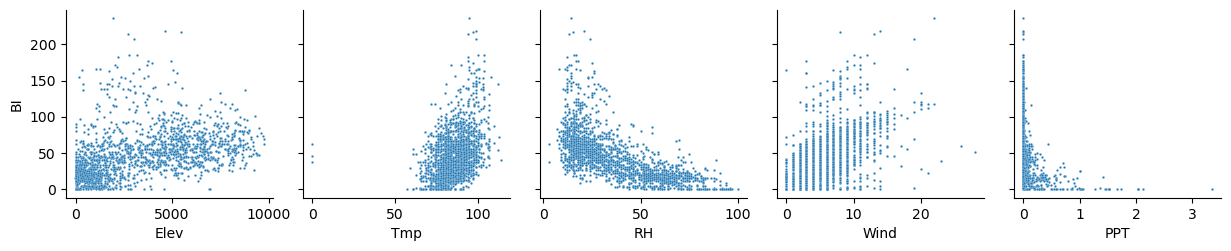

In [20]:
import seaborn as sns

sns.pairplot(wildfire_df_xu,
            x_vars=["Elev", "Tmp", "RH","Wind","PPT"],
            y_vars=['BI'],plot_kws={"s": 3})

Pre-processing - Normalize inputs to -1 - 1

In [21]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler

scaler = MinMaxScaler(feature_range=(-0.99, 0.99),copy=True, clip=False)

for s in ["Elev", "Tmp", "RH","Wind","PPT"]:
    scaler = MinMaxScaler(feature_range=(-1, 1),copy=True, clip=False)
    transformed_values = scaler.fit_transform(np.expand_dims(wildfire_df_xu[s].values,1)).reshape(-1)
    
    wildfire_df_xu[s+'_standard'] = transformed_values
    
scaler = StandardScaler(copy=True)
bi_transformed_values = scaler.fit_transform(np.expand_dims(wildfire_df_xu['BI'].values,1)).reshape(-1)
wildfire_df_xu['BI_standard'] = bi_transformed_values

In [23]:
wildfire_df_xu = wildfire_df_xu[wildfire_df_xu['Tmp_standard']>-0.6]

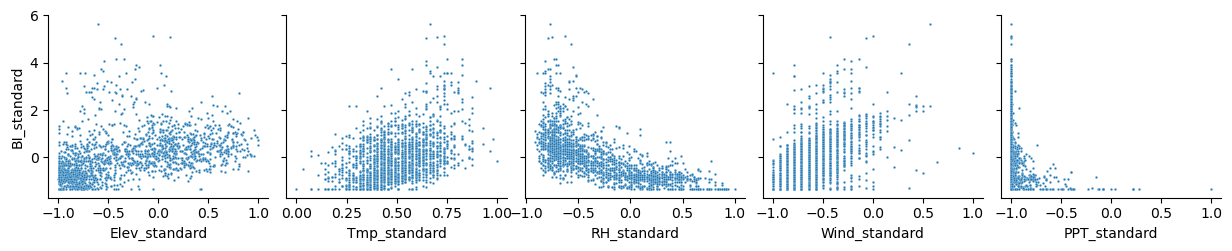

In [24]:
sns.pairplot(wildfire_df_xu,
            x_vars=["Elev_standard", "Tmp_standard", "RH_standard","Wind_standard","PPT_standard"],
            y_vars=['BI_standard'],plot_kws={"s": 3})

Take a subet

Plot on Map

In [277]:
wildfire_df_xu_sub = wildfire_df_xu.sample(n=800)

## Fit Single QR Model First


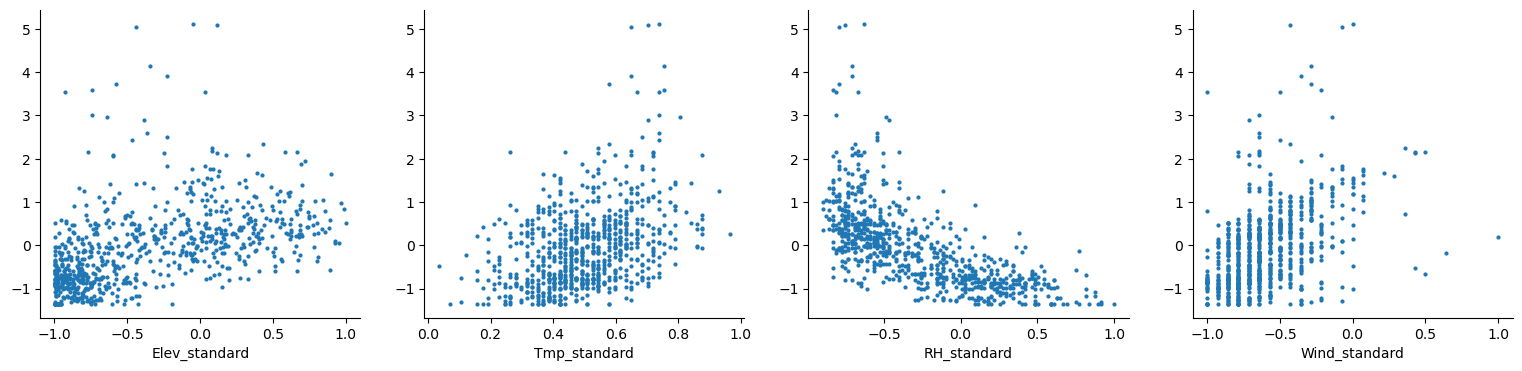

In [278]:
fig, ax = plt.subplots(1,4, figsize=(19,4))
for i,x_var_name in enumerate(["Elev_standard", "Tmp_standard", "RH_standard","Wind_standard"]):
    
    ax[i].scatter(wildfire_df_xu_sub[x_var_name],
                  wildfire_df_xu_sub['BI_standard'], s= 4)
    ax[i].spines[['right', 'top']].set_visible(False)
    ax[i].set_xlabel(x_var_name)

In [279]:
import arviz as az

In [280]:
np.random.seed(1)

Step:  0  Time Taken:  1.4866969585418701
Step:  5000  Time Taken:  50.03893208503723
Step:  10000  Time Taken:  53.60235333442688
Step:  15000  Time Taken:  53.314457178115845


/var/folders/0p/10_vdl_n673_r_lydsdd278m0000gn/T/ipykernel_15417/2744269533.py:147: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  b0_cis = az.hdi(b0_samples.T[n_burn_in:])
/var/folders/0p/10_vdl_n673_r_lydsdd278m0000gn/T/ipykernel_15417/2744269533.py:150: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  b1_cis = az.hdi(b1_samples.T[n_burn_in:])


Step:  0  Time Taken:  1.4846808910369873
Step:  5000  Time Taken:  50.259727001190186
Step:  10000  Time Taken:  49.594727993011475
Step:  15000  Time Taken:  49.12761974334717


/var/folders/0p/10_vdl_n673_r_lydsdd278m0000gn/T/ipykernel_15417/2744269533.py:147: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  b0_cis = az.hdi(b0_samples.T[n_burn_in:])
/var/folders/0p/10_vdl_n673_r_lydsdd278m0000gn/T/ipykernel_15417/2744269533.py:150: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  b1_cis = az.hdi(b1_samples.T[n_burn_in:])


Step:  0  Time Taken:  1.4417920112609863
Step:  5000  Time Taken:  50.28061604499817
Step:  10000  Time Taken:  49.44863986968994
Step:  15000  Time Taken:  49.44568705558777


/var/folders/0p/10_vdl_n673_r_lydsdd278m0000gn/T/ipykernel_15417/2744269533.py:147: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  b0_cis = az.hdi(b0_samples.T[n_burn_in:])
/var/folders/0p/10_vdl_n673_r_lydsdd278m0000gn/T/ipykernel_15417/2744269533.py:150: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  b1_cis = az.hdi(b1_samples.T[n_burn_in:])


Step:  0  Time Taken:  1.4574058055877686
Step:  5000  Time Taken:  52.29150104522705
Step:  10000  Time Taken:  51.50857210159302
Step:  15000  Time Taken:  49.8340950012207


/var/folders/0p/10_vdl_n673_r_lydsdd278m0000gn/T/ipykernel_15417/2744269533.py:147: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  b0_cis = az.hdi(b0_samples.T[n_burn_in:])
/var/folders/0p/10_vdl_n673_r_lydsdd278m0000gn/T/ipykernel_15417/2744269533.py:150: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  b1_cis = az.hdi(b1_samples.T[n_burn_in:])


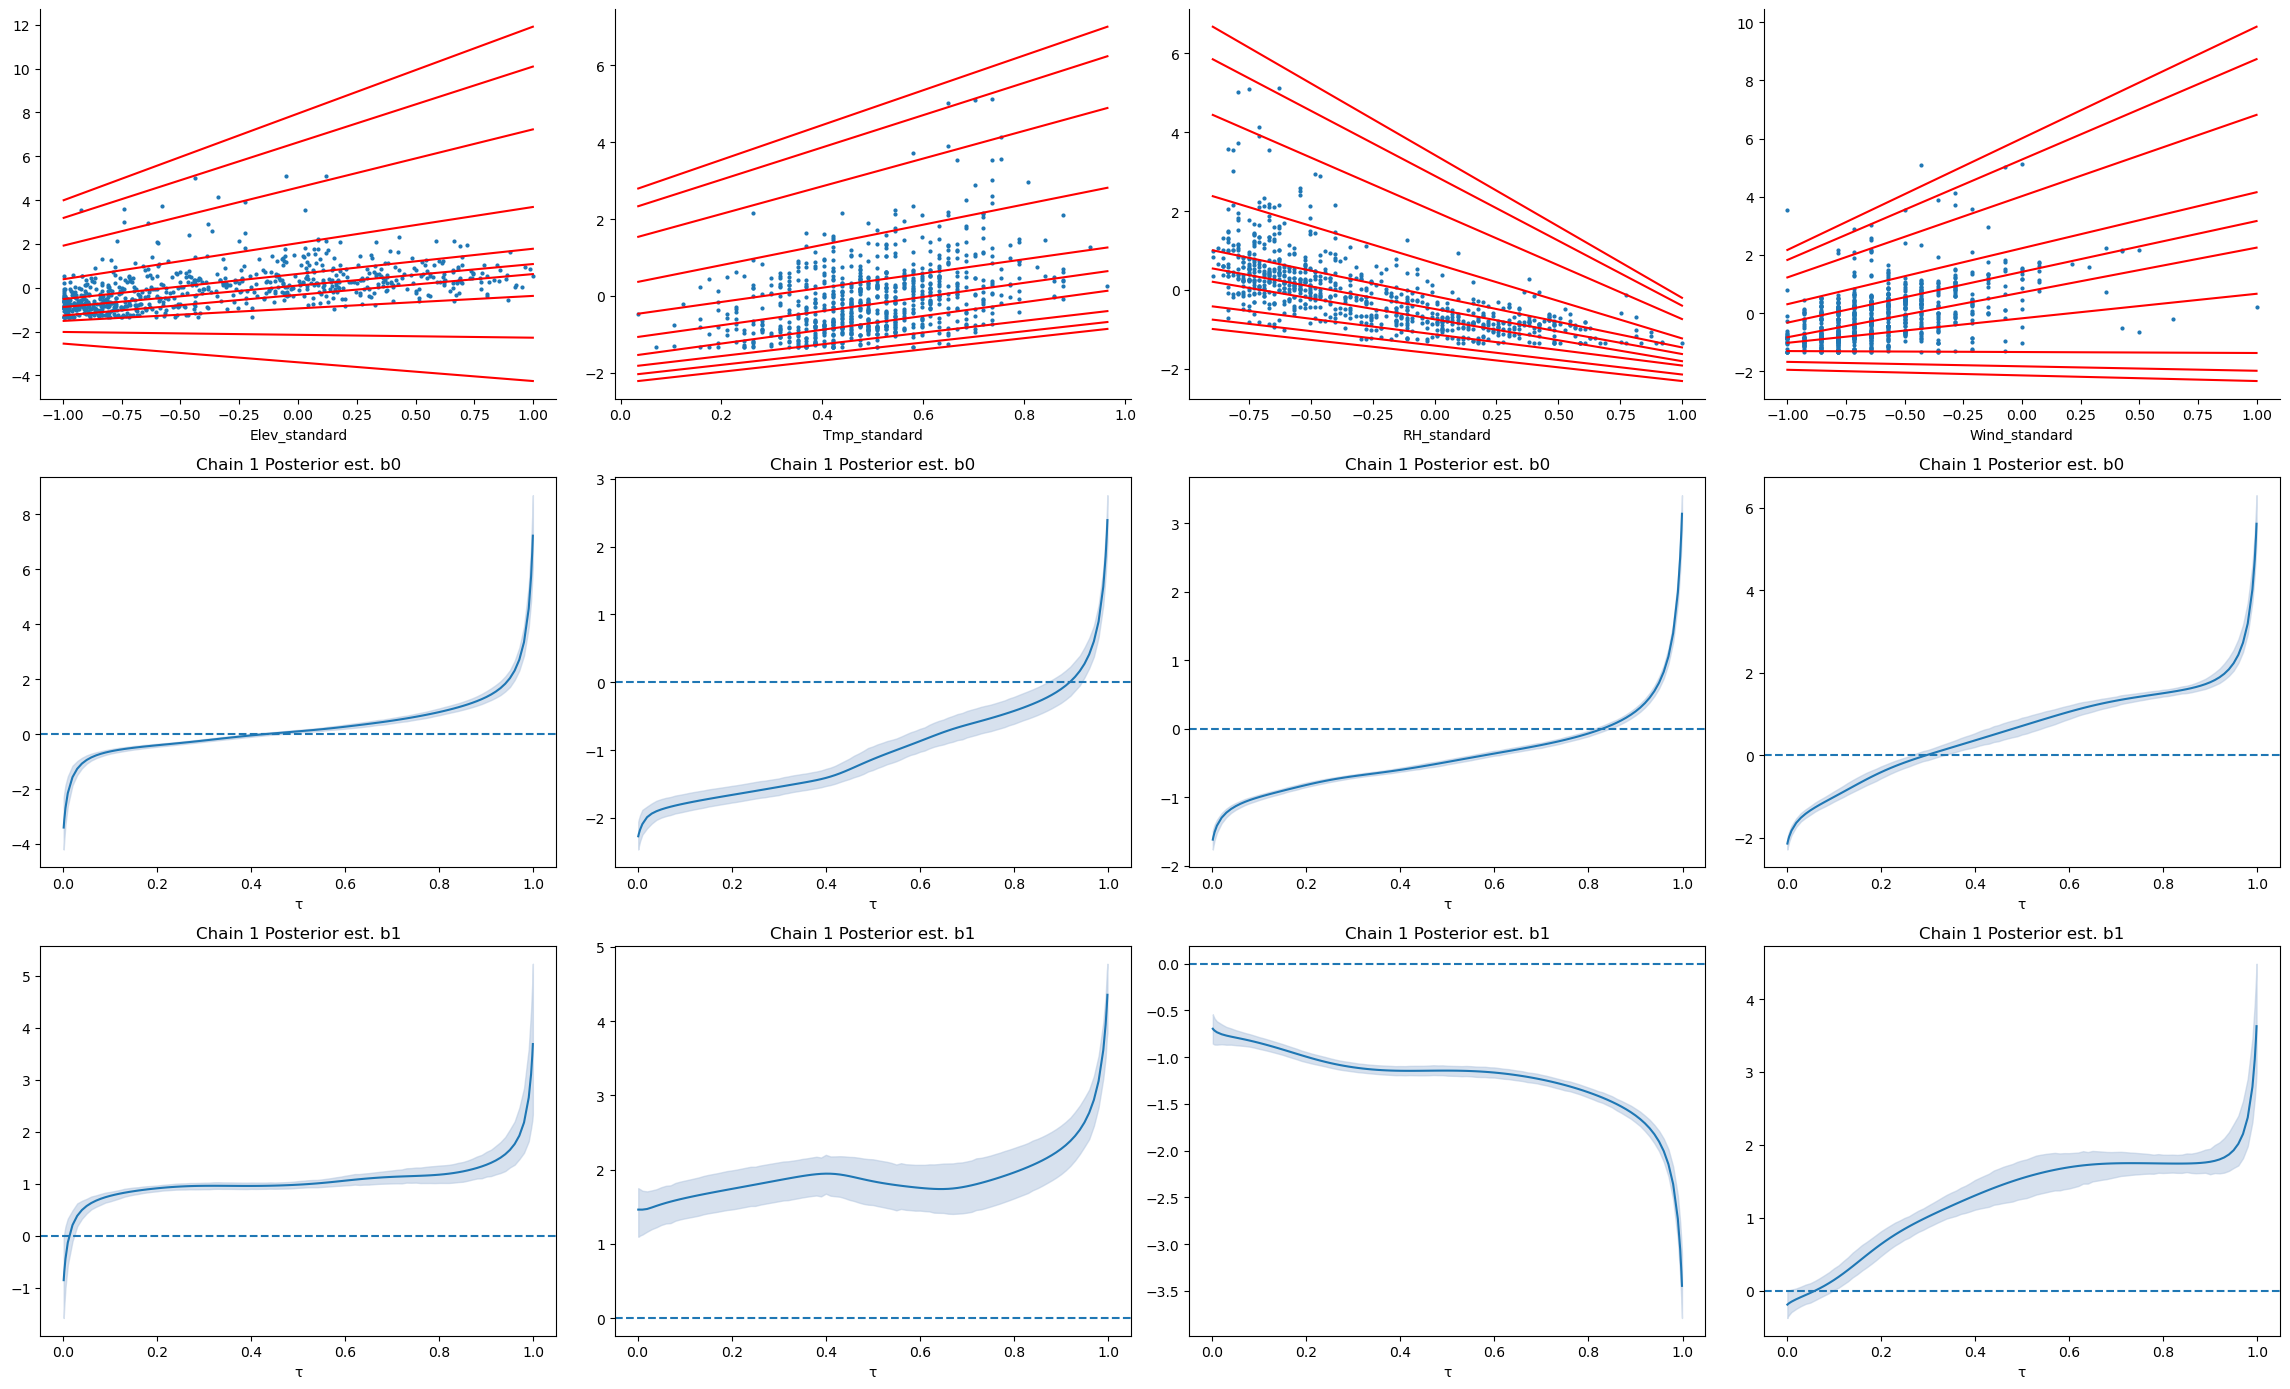

In [281]:
from Single_Var_QR import SingleQRSampler_T_4_block

np.random.seed(1234)

fig, ax = plt.subplots(3,4, figsize=(23,14))

chain_output_collate = {}
sampler_collector_collate = {}

for ax_id, x_var_name in enumerate(["Elev_standard", "Tmp_standard", "RH_standard","Wind_standard"]):

    
    x_var = wildfire_df_xu_sub[x_var_name].values
    y_var = wildfire_df_xu_sub['BI_standard'].values
    
    
    quantile_dist = 't'
    prior_on_t = True

    # Choose no. of chains
    n_chains = 1
    n_steps = 20000
    n_burn_in = 5000

    # Set Grid of tau values
    tau_grid_expanded = np.array([round(-0.01 + 0.01 * i,2) for i in range(103)])
    tau_grid = np.array([round(0.01 + 0.01 * i,2) for i in range(99)])
    knot_points_grid = np.arange(0.1,1,0.1)

    data_size = n_data
    tau_upper_tail = 1-1/(2*data_size)
    tau_lower_tail = 1/(2*data_size)
    lower_seq = np.flip(geometric_seq(0.01, tau_lower_tail, 0.005, upper=False))
    upper_seq = geometric_seq(0.99, tau_upper_tail, 0.005)

    tau_grid = np.array([round(0.01 + 0.01 * i,2) for i in range(99)])
    tau_grid = np.concatenate([lower_seq, tau_grid, upper_seq])

    tau_grid_expanded = np.concatenate([np.array([-0.01,0]),
                                        tau_grid,
                                        np.array([1,1.01])])

    # Run Sampler
    sampler_collecter_4blockt = [SingleQRSampler_T_4_block(y_var,
                                        x_var,          
                                        C_1 = 0.3,
                                        lambda_step_size_1 = 3,
                                        alpha_step_size_1 = 0.4,
                                        a_target_1 = 0.228,
                                        C_2 = 0.3,
                                        lambda_step_size_2 = 3,
                                        alpha_step_size_2 = 0.4,
                                        a_target_2 = 0.228,
                                        C_3 = 0.5,
                                        lambda_step_size_3 = 3,
                                        alpha_step_size_3 = 0.4,
                                        a_target_3 = 0.228,
                                        C_4 = 0.3,
                                        lambda_step_size_4 = 3,
                                        alpha_step_size_4 = 0.4,
                                        a_target_4 = 0.228,
                                        tau_grid_expanded = tau_grid_expanded,
                                        tau_grid = tau_grid,     
                                        knot_points_grid = knot_points_grid,
                                        am_lamb_block1_init = (2.38**2)/(9),
                                        am_lamb_block2_init = (2.38**2)/(9),
                                        am_lamb_block3_init = (2.38**2)/4,
                                        am_lamb_block4_init = (2.38**2)/(9*2+4),
                                        alpha_kappa = 0.1,
                                        beta_kappa = 0.1,
                                        eps_1 = 0,
                                        eps_2 = 0,
                                        base_quantile_mean=0.0,
                                        base_quantile_sd=1.0,
                                        base_quantile_v=1.0,
                                        base_quantile_dist=quantile_dist,
                                        prior_on_t=prior_on_t,
                                        splice=True) for _ in range(n_chains)]

    chain_outputs = [sampler_c.sample(n_steps=n_steps) for sampler_c in sampler_collecter_4blockt]

    sampler_collecter = sampler_collecter_4blockt
    
    chain_output_collate[x_var_name] = chain_outputs
    sampler_collector_collate[x_var_name] = sampler_collecter_4blockt[0]
    
    # Get sample quantile lines
    sample_quantiles = [0.01,0.05, 0.25, 0.5, 0.75, 0.95,0.99]
    sample_quantiles = [0.00125,0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99,0.9975,1]
    #sample_quantiles = [0.5]

    for sq in sample_quantiles:
        for i in range(n_chains):
            beta_0_samps, beta_1_samps = generate_beta_samples(tau_input=sq,
                                                          tau_grid=tau_grid_expanded,
                                                          w_approx_store=chain_outputs[i]['w'],
                                                          mu_store=chain_outputs[i]['mu'],
                                                          gamma_store=chain_outputs[i]['gamma'],
                                                          sigma_1_store=chain_outputs[i]['sigma_1'],
                                                          sigma_2_store=chain_outputs[i]['sigma_2'],
                                                          base_quantile_dist=quantile_dist,
                                                              v_store=chain_outputs[i]['v'])
            x_var_sorted = np.sort(x_var)
            y_pred_samples = np.array([b0 + b1*x_var_sorted for b0,b1 in zip(beta_0_samps, beta_1_samps)])
            y_pred_samples = y_pred_samples[n_burn_in:]

            ax[0, ax_id].plot(x_var_sorted, y_pred_samples.mean(0), color='red')
    
    # Plot
    ax[0, ax_id].scatter(wildfire_df_xu_sub[x_var_name],wildfire_df_xu_sub['BI_standard'], s= 4)
    ax[0, ax_id].spines[['right', 'top']].set_visible(False)
    ax[0, ax_id].set_xlabel(x_var_name)
    
    
    # Get beta values
    chain_store = []
    for i in range(n_chains):
        b0_val_samples = []
        b1_val_samples = []
        for sq in tau_grid:
            beta_0_samps, beta_1_samps = generate_beta_samples(tau_input=sq,
                                                          tau_grid=tau_grid_expanded,
                                                          w_approx_store=chain_outputs[i]['w'],
                                                          mu_store=chain_outputs[i]['mu'],
                                                          gamma_store=chain_outputs[i]['gamma'],
                                                          sigma_1_store=chain_outputs[i]['sigma_1'],
                                                          sigma_2_store=chain_outputs[i]['sigma_2'],
                                                          base_quantile_dist=quantile_dist,
                                                              v_store=chain_outputs[i]['v'])

            b0_val_samples.append(beta_0_samps)
            b1_val_samples.append(beta_1_samps)

        b0_val_samples = np.array(b0_val_samples)
        b1_val_samples = np.array(b1_val_samples)

        chain_store.append([b0_val_samples, b1_val_samples])
        
    # Plot beta values

    for c in range(n_chains):

        b0_samples, b1_samples = chain_store[c]

        # Get b0 b1 means and CIs
        b0_mean = b0_samples.T[n_burn_in:].mean(0)
        b0_cis = az.hdi(b0_samples.T[n_burn_in:])

        b1_mean = b1_samples.T[n_burn_in:].mean(0)
        b1_cis = az.hdi(b1_samples.T[n_burn_in:])


        # Plot values
        # Beta 0
        ax[1,ax_id].plot(tau_grid, b0_mean, color='tab:blue')
        ax[1,ax_id].fill_between(tau_grid, b0_cis[:,0],
                        b0_cis[:,1], color='lightsteelblue', alpha=.5)
        
        # Beta 1
        ax[2,ax_id].plot(tau_grid, b1_mean, color='tab:blue')
        ax[2,ax_id].fill_between(tau_grid, b1_cis[:,0],
                        b1_cis[:,1], color='lightsteelblue', alpha=.5)

        ax[1,ax_id].title.set_text(f"Chain {c+1} Posterior est. b0")
        ax[2,ax_id].title.set_text(f"Chain {c+1} Posterior est. b1")

        ax[1,ax_id].set_xlabel('τ')
        ax[2,ax_id].set_xlabel('τ')
        
        ax[1, ax_id].axhline(y=0,linestyle='--')
        ax[2, ax_id].axhline(y=0,linestyle='--')

plt.tight_layout()

Fit Joint QR Models

In [283]:
from epa import *

In [284]:
from geopy.distance import geodesic

def haversine(lat1, lon1, lat2, lon2):
    return geodesic((lat1, lon1), (lat2, lon2)).km

In [285]:
x_var = wildfire_df_xu_sub['RH_standard'].values
y_var = wildfire_df_xu_sub['BI_standard'].values

z_lat = wildfire_df_xu_sub['Lat'].values
z_lon = wildfire_df_xu_sub['Long'].values

num_points = len(z_lat)
distance_matrix = np.zeros((num_points, num_points))

for i in range(num_points):
    for j in range(num_points):
        distance_matrix[i, j] = haversine(z_lat[i], z_lon[i], z_lat[j], z_lon[j])


In [286]:
# Convert to similarity matrix
d_norm = distance_matrix/np.max(distance_matrix)
sim_mat = 1-d_norm + 0.01

Do Agglo Clustering on Distance Matrix First

In [348]:
sim_mat

array([[1.01      , 0.45332134, 0.87307329, ..., 0.22834814, 0.88469635,
        0.90704599],
       [0.45332134, 1.01      , 0.59012261, ..., 0.77752486, 0.33838364,
        0.54974964],
       [0.87307329, 0.59012261, 1.01      , ..., 0.36390896, 0.7533271 ,
        0.96189699],
       ...,
       [0.22834814, 0.77752486, 0.36390896, ..., 1.01      , 0.1189043 ,
        0.32131232],
       [0.88469635, 0.33838364, 0.7533271 , ..., 0.1189043 , 1.01      ,
        0.78217876],
       [0.90704599, 0.54974964, 0.96189699, ..., 0.32131232, 0.78217876,
        1.01      ]])

In [371]:
from sklearn.cluster import AgglomerativeClustering
import numpy as np

clustering = AgglomerativeClustering(n_clusters=2, affinity='precomputed', linkage='complete')
clusters = clustering.fit_predict(sim_mat)

In [372]:
agglo_pre_clusters = clusters

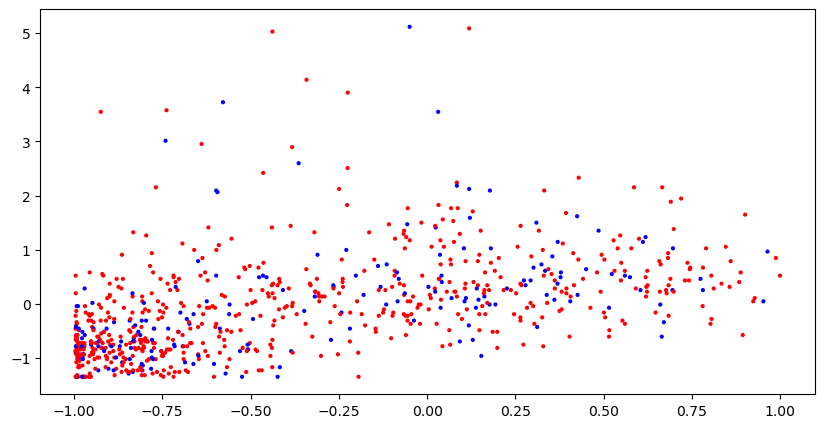

In [373]:
fig,ax = plt.subplots(figsize=(10,5))
agglo_cols = ['red','blue','green']

ax.scatter(x=wildfire_df_xu_sub['Elev_standard'],y=wildfire_df_xu_sub['BI_standard'], s=4,
          color=[agglo_cols[i] for i in agglo_pre_clusters])

In [377]:
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

# Assuming wildfire_data_df_xu is your DataFrame
# Create a GeoDataFrame from your DataFrame
geometry = [Point(xy) for xy in zip(wildfire_df_xu_sub['Long'], wildfire_df_xu_sub['Lat'])]
geo_df = gpd.GeoDataFrame(wildfire_df_xu_sub, geometry=geometry)

In [378]:
# Load the GeoDataFrame for USA states
usa_states = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Plotting the map of the USA with state boundaries
fig, ax = plt.subplots(figsize=(10, 6))
usa_states.boundary.plot(ax=ax, linewidth=1)
geo_df.plot(ax=ax, marker='o', color='BI_standard', legend=True, markersize=50, cmap='viridis')


/var/folders/0p/10_vdl_n673_r_lydsdd278m0000gn/T/ipykernel_15417/407001960.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  usa_states = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


ValueError: Can only specify one of 'values' and 'color' kwargs

AttributeError: module 'PIL' has no attribute 'Image'

<Figure size 1000x600 with 1 Axes>

In [380]:
from mpl_toolkits.basemap import Basemap

# Assuming wildfire_data_df_xu is your DataFrame
latitudes = wildfire_df_xu_sub['Lat'].values
longitudes = wildfire_df_xu_sub['Long'].values
bi_standard_values = wildfire_df_xu_sub['BI_standard'].values

# Plotting the map of the USA
fig = plt.figure(figsize=(12, 8))
m = Basemap(projection='lcc', resolution='h', 
            lat_0=37.5, lon_0=-96, width=1E6, height=1.2E6)
m.drawcountries(linewidth=0.5, color='black')
m.drawstates(linewidth=1, color='black')

# Convert latitude and longitude to x and y coordinates
x, y = m(longitudes, latitudes)

# Plot points colored by 'BI_standard'
sc = m.scatter(x, y, c=bi_standard_values, cmap='viridis', s=50, edgecolor='k', marker='o', alpha=0.7)

# Add colorbar
cbar = m.colorbar(sc, location='right', pad="5%")
cbar.set_label('BI_standard')

plt.title('Wildfire Data Map with State Boundaries')
plt.show()

[autoreload of numpy.core.overrides failed: Traceback (most recent call last):
  File "/Users/tzehongti/miniforge3/envs/pymc_env_4/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/Users/tzehongti/miniforge3/envs/pymc_env_4/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 455, in superreload
    module = reload(module)
  File "/Users/tzehongti/miniforge3/envs/pymc_env_4/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/Users/tzehongti/miniforge3/envs/pymc_env_4/lib/python3.10/site-packages/numpy/core/overrides.py", line 8, in <module>
    from numpy.core._multiarray_umath import (
ImportError: cannot import name '_ArrayF

[autoreload of numpy.lib.function_base failed: Traceback (most recent call last):
  File "/Users/tzehongti/miniforge3/envs/pymc_env_4/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/Users/tzehongti/miniforge3/envs/pymc_env_4/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 455, in superreload
    module = reload(module)
  File "/Users/tzehongti/miniforge3/envs/pymc_env_4/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/Users/tzehongti/miniforge3/envs/pymc_env_4/lib/python3.10/site-packages/numpy/lib/function_base.py", line 26, in <module>
    from numpy.core.multiarray import (
ImportError: cannot import name '_place'

[autoreload of llvmlite.ir.values failed: Traceback (most recent call last):
  File "/Users/tzehongti/miniforge3/envs/pymc_env_4/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/Users/tzehongti/miniforge3/envs/pymc_env_4/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 480, in superreload
    update_generic(old_obj, new_obj)
  File "/Users/tzehongti/miniforge3/envs/pymc_env_4/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 377, in update_generic
    update(a, b)
  File "/Users/tzehongti/miniforge3/envs/pymc_env_4/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 329, in update_class
    if update_generic(old_obj, new_obj):
  File "/Users/tzehongti/miniforge3/envs/pymc_env_4/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 377, in update_generic
    update(a, b)
  File "/Users/tzehongti/miniforge3/envs/pymc_env_4/lib/pyth

[autoreload of numba.core.types.npytypes failed: Traceback (most recent call last):
  File "/Users/tzehongti/miniforge3/envs/pymc_env_4/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/Users/tzehongti/miniforge3/envs/pymc_env_4/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 480, in superreload
    update_generic(old_obj, new_obj)
  File "/Users/tzehongti/miniforge3/envs/pymc_env_4/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 377, in update_generic
    update(a, b)
  File "/Users/tzehongti/miniforge3/envs/pymc_env_4/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 345, in update_class
    update_instances(old, new)
  File "/Users/tzehongti/miniforge3/envs/pymc_env_4/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 299, in update_instances
    refs = gc.get_referrers(old)
KeyboardInterrupt
]
[autoreload of numba.core

[autoreload of numba.core.debuginfo failed: Traceback (most recent call last):
  File "/Users/tzehongti/miniforge3/envs/pymc_env_4/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/Users/tzehongti/miniforge3/envs/pymc_env_4/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 480, in superreload
    update_generic(old_obj, new_obj)
  File "/Users/tzehongti/miniforge3/envs/pymc_env_4/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 377, in update_generic
    update(a, b)
  File "/Users/tzehongti/miniforge3/envs/pymc_env_4/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 345, in update_class
    update_instances(old, new)
  File "/Users/tzehongti/miniforge3/envs/pymc_env_4/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 299, in update_instances
    refs = gc.get_referrers(old)
KeyboardInterrupt
]
[autoreload of numba.core.cgut

[autoreload of numba.core.generators failed: Traceback (most recent call last):
  File "/Users/tzehongti/miniforge3/envs/pymc_env_4/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/Users/tzehongti/miniforge3/envs/pymc_env_4/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 480, in superreload
    update_generic(old_obj, new_obj)
  File "/Users/tzehongti/miniforge3/envs/pymc_env_4/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 377, in update_generic
    update(a, b)
  File "/Users/tzehongti/miniforge3/envs/pymc_env_4/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 345, in update_class
    update_instances(old, new)
  File "/Users/tzehongti/miniforge3/envs/pymc_env_4/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 299, in update_instances
    refs = gc.get_referrers(old)
KeyboardInterrupt
]
[autoreload of numba.core.rem

[autoreload of numba.core.extending failed: Traceback (most recent call last):
  File "/Users/tzehongti/miniforge3/envs/pymc_env_4/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/Users/tzehongti/miniforge3/envs/pymc_env_4/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 480, in superreload
    update_generic(old_obj, new_obj)
  File "/Users/tzehongti/miniforge3/envs/pymc_env_4/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 377, in update_generic
    update(a, b)
  File "/Users/tzehongti/miniforge3/envs/pymc_env_4/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 345, in update_class
    update_instances(old, new)
  File "/Users/tzehongti/miniforge3/envs/pymc_env_4/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 299, in update_instances
    refs = gc.get_referrers(old)
KeyboardInterrupt
]
[autoreload of numba.core.tran

[autoreload of numba.core.ir_utils failed: Traceback (most recent call last):
  File "/Users/tzehongti/miniforge3/envs/pymc_env_4/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/Users/tzehongti/miniforge3/envs/pymc_env_4/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 480, in superreload
    update_generic(old_obj, new_obj)
  File "/Users/tzehongti/miniforge3/envs/pymc_env_4/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 377, in update_generic
    update(a, b)
  File "/Users/tzehongti/miniforge3/envs/pymc_env_4/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 345, in update_class
    update_instances(old, new)
  File "/Users/tzehongti/miniforge3/envs/pymc_env_4/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 299, in update_instances
    refs = gc.get_referrers(old)
KeyboardInterrupt
]
[autoreload of numba.core.descr

[autoreload of numba.stencils.stencilparfor failed: Traceback (most recent call last):
  File "/Users/tzehongti/miniforge3/envs/pymc_env_4/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/Users/tzehongti/miniforge3/envs/pymc_env_4/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 480, in superreload
    update_generic(old_obj, new_obj)
  File "/Users/tzehongti/miniforge3/envs/pymc_env_4/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 377, in update_generic
    update(a, b)
  File "/Users/tzehongti/miniforge3/envs/pymc_env_4/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 345, in update_class
    update_instances(old, new)
  File "/Users/tzehongti/miniforge3/envs/pymc_env_4/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 299, in update_instances
    refs = gc.get_referrers(old)
KeyboardInterrupt
]
[autoreload of numba.c

[autoreload of numba.misc.llvm_pass_timings failed: Traceback (most recent call last):
  File "/Users/tzehongti/miniforge3/envs/pymc_env_4/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/Users/tzehongti/miniforge3/envs/pymc_env_4/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 480, in superreload
    update_generic(old_obj, new_obj)
  File "/Users/tzehongti/miniforge3/envs/pymc_env_4/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 377, in update_generic
    update(a, b)
  File "/Users/tzehongti/miniforge3/envs/pymc_env_4/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 345, in update_class
    update_instances(old, new)
  File "/Users/tzehongti/miniforge3/envs/pymc_env_4/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 299, in update_instances
    refs = gc.get_referrers(old)
KeyboardInterrupt
]
[autoreload of numba.c

In [ ]:
1+1

[autoreload of numba.core.compiler_machinery failed: Traceback (most recent call last):
  File "/Users/tzehongti/miniforge3/envs/pymc_env_4/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/Users/tzehongti/miniforge3/envs/pymc_env_4/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 455, in superreload
    module = reload(module)
  File "/Users/tzehongti/miniforge3/envs/pymc_env_4/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/Users/tzehongti/miniforge3/envs/pymc_env_4/lib/python3.10/site-packages/numba/core/compiler_machinery.py", line 16, in <module>
    _termcolor = errors.termcolor()
  File "/Users/tzehongti/minifor

[autoreload of numba.types.utils failed: Traceback (most recent call last):
  File "/Users/tzehongti/miniforge3/envs/pymc_env_4/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/Users/tzehongti/miniforge3/envs/pymc_env_4/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 480, in superreload
    update_generic(old_obj, new_obj)
  File "/Users/tzehongti/miniforge3/envs/pymc_env_4/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 377, in update_generic
    update(a, b)
  File "/Users/tzehongti/miniforge3/envs/pymc_env_4/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 345, in update_class
    update_instances(old, new)
  File "/Users/tzehongti/miniforge3/envs/pymc_env_4/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 299, in update_instances
    refs = gc.get_referrers(old)
KeyboardInterrupt
]
[autoreload of numba.types.abstra

In [287]:
c1_params = chain_output_collate['RH_standard'][0]

In [125]:
Ys = y_var
Xs = x_var

In [288]:
start_time = time.time()

lambda_init = 'tight' # 'standard'/'tight'

# similarity mat
tau = 2
#lambda_matrix = pairwise_distances(X=Zs.reshape(-1,1), metric=exp_sim_func, tau=tau)
lambda_matrix = sim_mat

# Calc lambda

# intialize 
names_used = np.array([1,2])
alpha_samp = 1

# try with good distance function
partition_samp = np.array([1 if x<= 0 else 2 for x in Xs])  # Set initialization for lambda
partition_samp = inds_train.copy()



# Scramble initialization after
partition_samp = np.array([1 if np.random.uniform(0,1)<0.5 else 2 for x in Xs])  # try no initialization
partition_init  = partition_samp.astype('int')

delta_samp = 0
sim_mat = lambda_matrix
order_samp = np.arange(len(Ys))
np.random.shuffle(order_samp)


#### gibbs sampling hyper parameters
n_gibbs = 2000
n_burn_in = 1000
k = 150 # no. of numbers to permute order
n_chain = 2

# GRW sampler param
rw_sd = 0.2

# alpha prior -> Want alpha to be small,  gammma prior so mean = a/b
alpha_init = 0.005
a_alpha = 1
b_alpha = 200
alpha_bounds = [0,1e99]

# delta prior -> Want delta to be smal lalso gammma prior so mean = a/b
a_delta = 1
b_delta = 100
w_delta = 0.5
delta_bounds = [0,1]
delta_init = 0

# Tau prior
sample_tau = False
tau_bounds = [0,99]
a_tau = 4
b_tau = 2
tau_init = 1

labels_used = np.array([1,2])

reordering = True
use_split_merge_step = False


# phi sample - w1, w2, mu,gamma,sigma1,sigma2 - store as a vector

##############################
#### initialize QR Params ####
##############################
splice = True
m = 9

if not prior_on_t:
    phi_init = np.zeros([len(labels_used),
                    m+m+4])
else:
    phi_init = np.zeros([len(labels_used),
                    m+m+5])


# Set tau grid
#tau_grid_expanded = np.array([round(-0.01 + 0.01 * i,2) for i in range(103)])
#tau_grid = np.array([round(0.01 + 0.01 * i,2) for i in range(99)])
knot_points_grid = np.arange(0.1,1,0.1)
m = len(knot_points_grid)

eta1_init = np.zeros([len(labels_used),
                     len(tau_grid)])
eta2_init = np.zeros([len(labels_used),
                     len(tau_grid)])
    
# Get lambda PDF
h=0.1
lambd_collect = calc_lambd_grid_uncorr(knot_points_grid.reshape(-1,1),
                                    h=h,
                                    rho_lambd_init=0.99)
lambd_grid = np.array(lambd_collect)
grid_pdf_vals = lamb_pdf(lambd_grid)
lambda_grid_log_prob = np.log(grid_pdf_vals)

#### Initialize Model Parameters
## GP Related hyperparameters
kappa_current = np.nan
rho_current = 0.1
lambd_current = 4
alpha_kappa = 3
beta_kappa = 1/3

## Regression related parametrs
mu_current = 0
gamma_current = 0
sigma_1_current = 1
sigma_2_current = 1


#### W samples 
# calc covariance matrix
cov_mat_knots_current = covariance_matrix_gp_uncorr(knot_points_grid.reshape(-1,1),
                                  lambd=lambd_current)
# Precompute Matrices
cov_matrices_G, A_matrices_G = precompute_approx_uncorr(tau_grid_expanded.reshape(-1,1),
                                                   knot_points_grid.reshape(-1,1),
                                                   lambda_grid=lambd_grid)

for j in range(len(labels_used)):
    
    # Initialise w1, w2 knots 
    w1_knot_points_current_j = np.array(c1_params['w1_knot'][n_steps-200:n_steps-1]).mean(0)

    w2_knot_points_current_j = np.array(c1_params['w2_knot'][n_steps-200:n_steps-1]).mean(0)

    
    remain_params_j = np.array([np.array(c1_params['mu'][n_steps-200:n_steps-1]).mean(0),
                                np.array(c1_params['gamma'][n_steps-200:n_steps-1]).mean(0),
                                np.array(c1_params['sigma_1'][n_steps-200:n_steps-1]).mean(0),
                                np.array(c1_params['sigma_2'][n_steps-200:n_steps-1]).mean(0)])


    if prior_on_t:
        v_hat = np.array(c1_params['v'][n_steps-200:n_steps-1]).mean()
    else:
        v_hat=1.0
    
            
    if prior_on_t:
    # Store into phi_j
        phi_j = np.concatenate([w1_knot_points_current_j,
                                w2_knot_points_current_j,
                                remain_params_j, np.array([v_hat])])
    else:
        phi_j = np.concatenate([w1_knot_points_current_j,
                            w2_knot_points_current_j,
                            remain_params_j])

    phi_init[j] = phi_j
    
    #### Get associated Quantile Function for each phi_j ####
    w1_knot_prop = w1_knot_points_current_j
    w2_knot_prop = w2_knot_points_current_j
    # Get approx
    w1_approx_prop_j, lp_w1_j = calc_mixture_knot_approx_marginalized(w1_knot_prop,
                                                                    a_kappa=alpha_kappa,
                                                                    b_kappa=beta_kappa,
                                                                    tau_grid=tau_grid_expanded,
                                                                    A_g_matrices=A_matrices_G,
                                                                    cov_mat_knot_store=cov_matrices_G,
                                                                    lambda_grid_log_prob=lambda_grid_log_prob)
    
    w2_approx_prop_j, lp_w2_j = calc_mixture_knot_approx_marginalized(w2_knot_prop,
                                                                    a_kappa=alpha_kappa,
                                                                    b_kappa=beta_kappa,
                                                                    tau_grid=tau_grid_expanded,
                                                                    A_g_matrices=A_matrices_G,
                                                                    cov_mat_knot_store=cov_matrices_G,
                                                                    lambda_grid_log_prob=lambda_grid_log_prob)
    # Get Q function
    mu_j, gamma_j, sigma1_j, sigma2_j = phi_j[18],phi_j[19],phi_j[20],phi_j[21]

    # get Eta functions
    eta_1_j  = eta_function_i_vector(tau_input=tau_grid,
                               w_vals=w1_approx_prop_j,
                               tau_grid=tau_grid_expanded,
                               mean=0.0,
                               sd=1.0,
                               v=v_hat,
                               sigma=sigma1_j,
                               dist=quantile_dist)

    eta_2_j  = eta_function_i_vector(tau_input=tau_grid,
                           w_vals=w2_approx_prop_j,
                           tau_grid=tau_grid_expanded,
                           mean=0.0,
                           sd=1.0,
                           v=v_hat,
                           sigma=sigma2_j,
                           dist=quantile_dist)

    eta1_init[j] = eta_1_j
    eta2_init[j] = eta_2_j

In [289]:
Ys = y_var
Xs = x_var
Zs = None
sim_mat = sim_mat
partition_init = partition_init
phi_init = phi_init

tau_init =   tau_init
labels_used = labels_used
alpha_init = alpha_init
delta_init = delta_init
n_gibbs = n_gibbs
n_burn_in = n_burn_in
k = k
a_alpha = a_alpha
b_alpha = b_alpha
a_delta = a_delta
b_delta = b_delta
a_tau =  a_tau
b_tau =  b_tau
w_delta = 0.5
reordering = reordering
use_split_merge_step = use_split_merge_step
sample_tau = False

In [293]:
n = len(Ys)
# intialize 
names_used = labels_used
alpha_samp = alpha_init

delta_samp = delta_init
order_samp = np.arange(n)
np.random.shuffle(order_samp)

# initialize QR params
phi_samp = phi_init
eta1_samp = eta1_init
eta2_samp = eta2_init

partition_samp = partition_init
tau_samp = tau_init


#### gibbs sampling hyper parameters
n_gibbs = n_gibbs
k = k # no. of numbers to permute order

# GRW sampler param
rw_sd = 0.2

# alpha prior
a_alpha = a_alpha
b_alpha = b_alpha
alpha_bounds = [0,1e99]

# delta prior
a_delta = a_delta
b_delta = b_delta

assert (w_delta<=1) and (w_delta>=0)
w_delta = w_delta
delta_bounds = [0,1]
tau_bounds = [0,1e99]


partition_save = []
alpha_save = []
delta_save = []
phi_save = []
log_prob_save = []
sigma_reg_save = []
tau_save = []

# Track acceptance rates
split_merge_accept_save = []
tau_accept_save = []
delta_accept_save = []
order_accept_save = []
alpha_accept_save = []


s1 = time.time()
# Gibbs loop
for g in range(n_gibbs+n_burn_in):
    if g%100 == 0:
        e1 = time.time()
        print("Gibbs: ", g, " Time Taken: ", (e1-s1)/60)
        print("Active No Clusters: ", len(np.unique(partition_samp)))
        print("Active No Clusters: ", pd.Series(partition_samp).value_counts())
        s1 = time.time()

    # Get last term in order samp
    #last_term_samp = order_samp[-1]
    last_term_id = order_samp[-1]#np.where(order_samp == np.max(order_samp))[0][0]

    #print('Partition Update')
    # Draw sample for the final term
    if prior_on_t:
        v_samp = phi_samp[-1]
    else:
        v_samp = 1.0
    
    partition_samp, phi_samp, names_used, \
        partition_factors, eta1_samp, eta2_samp = sample_conditional_i_clust_gibbs_opti_parallel_QR(
                                    i=last_term_id,
                                    order_place=0,
                                    partition=partition_samp,
                                    return_fac=True,
                                    pre_compute_factors=np.zeros(1),
                                    alpha=alpha_samp,
                                    delta=delta_samp,
                                    sim_mat=sim_mat,
                                    order=order_samp,
                                    phi=phi_samp,
                                    eta1_mat=eta1_samp, 
                                    eta2_mat=eta2_samp,
                                    y=Ys,
                                    x=Xs,
                                    A_matrices_G = A_matrices_G,
                                    cov_matrices_G = cov_matrices_G,
                                    lambda_grid_log_prob= lambda_grid_log_prob,
                                       w_cov_mat=cov_mat_knots_current,
                                      alpha_kappa=5,
                                      beta_kappa=1/3,
                                      tau_grid=tau_grid,
                                      tau_grid_expanded=tau_grid_expanded,
                                    base_quantile_mean=0.0,
                                     base_quantile_sd=1.0,
                                     base_quantile_v=v_samp,
                                     base_quantile_dist=quantile_dist,
                                    names_used=names_used,                      
                                    reordering=reordering,
                                    splice=splice,
                                    prior_on_t=prior_on_t)
    
    for o in list(range(len(order_samp)-2,-1,-1)):

        term_id = order_samp[o]#np.where(order_samp == o)[0][0]

        partition_samp, phi_samp, names_used,\
              eta1_samp, eta2_samp= sample_conditional_i_clust_gibbs_opti_parallel_QR(
                                        i=term_id,
                                        order_place=o,
                                        partition=partition_samp,
                                        return_fac=False,
                                        pre_compute_factors=partition_factors,
                                        alpha=alpha_samp,
                                        delta=delta_samp,
                                        sim_mat=sim_mat,
                                        order=order_samp,
                                        phi=phi_samp,
                                        eta1_mat=eta1_samp, 
                                        eta2_mat=eta2_samp,
                                        y=Ys,
                                        x=Xs,
                                        A_matrices_G = A_matrices_G,
                                    cov_matrices_G = cov_matrices_G,
                                    lambda_grid_log_prob= lambda_grid_log_prob,
                                    
                                           w_cov_mat=cov_mat_knots_current,
                                          alpha_kappa=5,
                                          beta_kappa=1/3,
                                          tau_grid=tau_grid,
                                          tau_grid_expanded=tau_grid_expanded,
                                        base_quantile_mean=0.0,
                                         base_quantile_sd=1.0,
                                         base_quantile_v=v_samp,
                                         base_quantile_dist=quantile_dist,
                                        names_used=names_used,
                                        reordering=reordering,
                                            prior_on_t=prior_on_t)

    """
    if use_split_merge_step:
    #### Split Merge step ####
        partition_samp,phi_samp, names_used,\
        sigma2_reg_samp, accept_samp = split_merge_step(partition_samp=partition_samp,
                                                    alpha=alpha_samp,
                                                    delta=delta_samp,
                                                    sim_mat=sim_mat,
                                                    order=order_samp,
                                                    phi_samp=phi_samp,
                                                    y=Ys,
                                                    x=Xs, 
                                                    sigma2_reg_samp=sigma2_reg_samp,
                                                    v_0=v_0,
                                                    sigma2_0=sigma2_0,
                                                    names_used=names_used, 
                                                    phi_base_mean=phi_mean_prior,
                                                    phi_base_cov=phi_cov_prior,
                                                    no_intermediate_steps=5)

        if g>n_burn_in:

            split_merge_accept_save.append(accept_samp)
    """

    partition_samp = partition_samp.astype('int')

    
    #print("Sampling Phi")
    phi_samp, eta1_samp, eta2_samp = sample_phi_QR(phi_cur=phi_samp,
                           eta1_cur=eta1_samp,
                           eta2_cur=eta2_samp,
                           n_steps=200,
                           y=Ys,
                           x=Xs,
                            A_matrices_G = A_matrices_G,
                        cov_matrices_G = cov_matrices_G,
                        lambda_grid_log_prob= lambda_grid_log_prob,
                        cov_mat_knots_init=cov_mat_knots_current,
                           partition=partition_samp,
                          tau_grid=tau_grid,
                           tau_grid_expanded=tau_grid_expanded,
                           base_quantile_mean=0.0,
                           base_quantile_sd=1.0,
                           base_quantile_v=1.0,
                          base_quantile_dist=quantile_dist,
                          prior_on_t=prior_on_t)

    # Sample ordering 
    #order_samp = permute_k(order_samp, k)
    #print("Sample Order")
    order_samp,order_accept_s = metropolis_step_order(order_current=order_samp,
                                    alpha=alpha_samp,
                                    delta=delta_samp,
                                    partition=partition_samp,
                                    sim_mat=sim_mat,
                                    k=k)

    if g>n_burn_in:
        order_accept_save.append(order_accept_s)

    #### Sample parameters, alpha, sigma
    #print("Sampling Alpha")
    alpha_samp, alpha_accept_s = metropolis_step_alpha(alpha_samp,
                                                    rw_sd,
                                                    a_alpha, b_alpha,
                                                    partition_samp,
                                                        delta_samp,
                                                        sim_mat,
                                                        order_samp,
                                                    bounds=alpha_bounds)

    if g>n_burn_in:
        alpha_accept_save.append(alpha_accept_s)

    #print("Sampling Delta")
    delta_samp, delta_accept_s = metropolis_step_delta(delta_samp, rw_sd,
                                                    a_delta, b_delta, w_delta,
                                                    partition_samp,
                                                        alpha_samp,
                                                        sim_mat,
                                                        order_samp,bounds=delta_bounds)

    if g>n_burn_in:
        delta_accept_save.append(delta_accept_s)

    # Update Tau + Sim mat
    if sample_tau:
        tau_samp, sim_mat, tau_accept_s = metropolis_step_tau(tau_samp, rw_sd, a_tau, b_tau,
                            partition_samp,
                                alpha_samp,
                                delta_samp,
                                sim_mat,
                                X=Zs.reshape(-1,1),
                        order=order_samp,bounds=tau_bounds)

        if g>n_burn_in:
            tau_accept_save.append(tau_accept_s)

    """
    # Calc log prob of result
    log_prob_samp = calc_log_joint(partition=partition_samp,
                                phi=phi_samp,
                                y=Ys,
                                x=Xs,
                                sim_mat=sim_mat,
                                order=order_samp,
                                alpha=alpha_samp,
                                delta=delta_samp,
                                sigma_reg = sigma_reg)
    """

    if g>n_burn_in:

        # Save sampled values
        #log_prob_save.append(log_prob_samp)
        partition_save.append(partition_samp)
        alpha_save.append(alpha_samp)
        delta_save.append(delta_samp)
        phi_save.append(phi_samp)
        tau_save.append(tau_samp)


acceptance_rates = {'Split Merge': np.mean(split_merge_accept_save),
                    'Tau': np.mean(tau_accept_save),
                    'Delta': np.mean(delta_accept_save),
                    'Order': np.mean(order_accept_save),
                    'Alpha': np.mean(alpha_accept_save)}

acceptance_rates = pd.DataFrame.from_dict(acceptance_rates, orient='index')
acceptance_rates.columns=['Acceptance Rate']
acceptance_rates


Gibbs:  0  Time Taken:  7.085005442301432e-06
Active No Clusters:  2
Active No Clusters:  2    408
1    392
dtype: int64
Gibbs:  100  Time Taken:  24.674046218395233
Active No Clusters:  2
Active No Clusters:  1    638
2    162
dtype: int64
Gibbs:  200  Time Taken:  25.477021384239197
Active No Clusters:  3
Active No Clusters:  1    581
2    205
3     14
dtype: int64
Gibbs:  300  Time Taken:  31.82375512123108
Active No Clusters:  3
Active No Clusters:  1    589
2    185
3     26
dtype: int64
Gibbs:  400  Time Taken:  29.2972034017245
Active No Clusters:  3
Active No Clusters:  1    544
2    145
3    111
dtype: int64
Gibbs:  500  Time Taken:  31.134916083017984
Active No Clusters:  3
Active No Clusters:  1    447
2    221
3    132
dtype: int64
Gibbs:  600  Time Taken:  29.78105439742406
Active No Clusters:  3
Active No Clusters:  1    473
2    181
3    146
dtype: int64
Gibbs:  700  Time Taken:  29.347992567221322
Active No Clusters:  3
Active No Clusters:  1    568
2    148
3     84
dt

/Users/tzehongti/miniforge3/envs/pymc_env_4/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/tzehongti/miniforge3/envs/pymc_env_4/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Acceptance Rate
Split Merge              NaN
Tau                      NaN
Delta               0.000000
Order               0.086043
Alpha               0.048524

Get clustering matrix

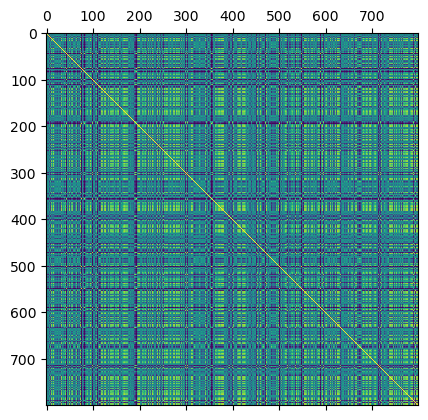

In [302]:
cluster_size_samples = np.array([len(np.unique(p)) for p in partition_save])
np.mean(cluster_size_samples)


normalized_sim_mat = calc_hit_matrix(partition_save,
                                     burn_samples=0,
                                     normalize=True)

plt.matshow(normalized_sim_mat)
plt.show()

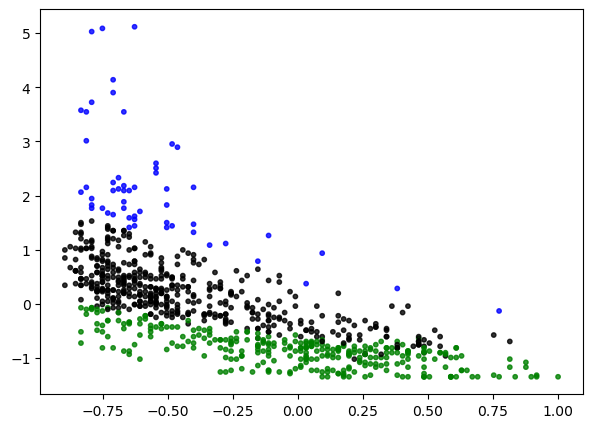

In [334]:
agglo_cluster_solution = agglo_cluster(sim_matrix=normalized_sim_mat,
                                       n_clust=3,
                                       linkage_type='complete')

fig, ax = plt.subplots(figsize=(7,5))


ax.scatter(X_train, y_train,
            s=10, color=[color_list[i] for i in agglo_cluster_solution], alpha=0.8)

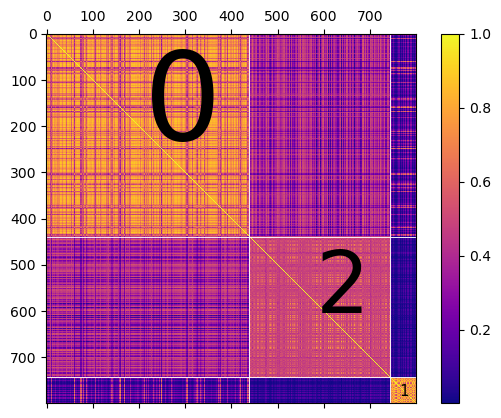

In [333]:
# Calculate c-vals
c_vals = calc_c_vals(agglo_cluster_solution, normalized_sim_mat)

sorted_clust_names = pd.Series(agglo_cluster_solution).value_counts().index

arranged_ids = []
for c in sorted_clust_names:

    clust_ids = np.where(agglo_cluster_solution==c)[0]
    c_vals_clust = c_vals[clust_ids]
    sorted_clust_ids =clust_ids[np.argsort(c_vals_clust)[::-1]]
    
    arranged_ids.append(sorted_clust_ids)
    
arranged_ids = np.concatenate(arranged_ids)

sorted_matrix = np.zeros((len(Ys),len(Ys)))

for i in range(len(Ys)):
    for j in range(len(Ys)):
        
        sorted_matrix[i,j] = normalized_sim_mat[arranged_ids[i], arranged_ids[j]]

figure = plt.figure()
axes = figure.add_subplot(111)

caxes = axes.matshow(sorted_matrix, cmap='plasma')
figure.colorbar(caxes)

clust_sizes = pd.Series(agglo_cluster_solution).value_counts().values

for clust_size,clust_name, n in zip(clust_sizes,sorted_clust_names,clust_sizes.cumsum()):
    
    axes.axvline(n-1,c='white',lw=0.65)
    axes.axhline(n-1,c='white',lw=0.65)

    axes.text(n-clust_size//2-10, n-clust_size//2+10, str(clust_name), color="k", fontsize=clust_size/5)


Get posterior samples

In [324]:
Q_sample_collect = []
x_vals_checker = []
omitted_samps = 0
omitted_samp_id = []
omitted_samp_out = []
#bad_samps1 = np.where(np.min(np.min(Q_sample_collect,1),1)<-30)[0]
#bad_samps2 = np.where(np.min(np.min(Q_sample_collect,1),1)>30)[0]


for i in range(n_gibbs-1):#range(n_gibbs-1): # range(n_gibbs-1):
    
    #if (i in bad_samps1) or (i in bad_samps2):
     #   continue
    
    # Get cluster
    partition_samp = partition_save[i]

    # Get phi samp
    phi_samp = phi_save[i]

    output_q_tx = []
    x_vals_arr = []
    # Iterate through each cluster
    for k in np.unique(partition_samp):

        # Extract data points + phi_k
        phi_k = phi_samp[k-1]

        point_ids = np.where(partition_samp==k)[0]

        # Extract X Values
        x_vals_k = X_train[point_ids]

        # Using phi generate the quantile regression function
        phi_samp_clust = phi_samp[k-1,:]
        m = (len(phi_samp_clust) - 4)// 2
        w1_knot_points_current = phi_samp_clust[0:m]
        w2_knot_points_current = phi_samp_clust[m:2*m]
        mu_current = phi_samp_clust[2*m]
        gamma_current = phi_samp_clust[2*m+1]
        #sigma_1_current = np.exp(phi_samp_clust[2*m+2])
        #sigma_2_current = np.exp(phi_samp_clust[2*m+3])
        sigma_1_current = phi_samp_clust[2*m+2]
        sigma_2_current = phi_samp_clust[2*m+3]
        
        if prior_on_t:
            v_current = phi_samp_clust[2*m+4]
        else:
            v_current = 1.0
        # Generate quantities
        
        # Generate sample of GP approx
        w1_approx_current, lp_w1_current = calc_mixture_knot_approx_marginalized(w1_knot_points_current,
                                                                                a_kappa=alpha_kappa,
                                                                                b_kappa=beta_kappa,
                                                                                tau_grid=tau_grid_expanded,
                                                                                A_g_matrices=A_matrices_G,
                                                                                cov_mat_knot_store=cov_matrices_G,
                                                                                lambda_grid_log_prob=lambda_grid_log_prob)

        w2_approx_current, lp_w2_current = calc_mixture_knot_approx_marginalized(w2_knot_points_current,
                                                                                a_kappa=alpha_kappa,
                                                                                b_kappa=beta_kappa,
                                                                                tau_grid=tau_grid_expanded,
                                                                                A_g_matrices=A_matrices_G,
                                                                                cov_mat_knot_store=cov_matrices_G,
                                                                                lambda_grid_log_prob=lambda_grid_log_prob)
        
        # Generate Q
        eta_1  = eta_function_i_vector(tau_input=tau_grid,
                            w_vals=w1_approx_current,
                            tau_grid=tau_grid_expanded,
                            mean=0.0,
                            sd=1.0,
                            v=v_current,
                            sigma=sigma_1_current,
                            dist=quantile_dist)

        eta_2  = eta_function_i_vector(tau_input=tau_grid,
                            w_vals=w2_approx_current,
                            tau_grid=tau_grid_expanded,
                            mean=0.0,
                            sd=1.0,
                            v=v_current,
                            sigma=sigma_2_current,
                            dist=quantile_dist)
        
        Q_tx  = mu_current + gamma_current * np.expand_dims(x_vals_k, -1) + \
            np.expand_dims((1-x_vals_k)/2, -1) * eta_1 + \
            np.expand_dims((1+x_vals_k)/2, -1) * eta_2
        
        beta_0_samp = mu_current + (eta_1 + eta_2)/2
        beta_1_samp = gamma_current + (eta_1 - eta_2)/2
        
        Q_tx_alt = np.array([b0 + b1*x_vals_k for b0,b1 in zip(beta_0_samp, beta_1_samp)])
        
        output_q_tx.append(Q_tx_alt.T)
        x_vals_arr.append(x_vals_k)

    output_q_tx = np.concatenate(output_q_tx,0)
    x_vals_arr = np.concatenate(x_vals_arr,0)
    
    sort_ids = np.argsort(x_vals_arr)
    x_vals_arr = x_vals_arr[sort_ids]
    output_q_tx = output_q_tx[sort_ids,:]
    
    # Optional
    if (np.max(output_q_tx) > 1e2) or (np.min(output_q_tx)<-1e2):
        omitted_samps += 1
        omitted_samp_id.append(i)
        omitted_samp_out.append(output_q_tx)
        continue
    
    Q_sample_collect.append(output_q_tx)
    x_vals_checker.append(x_vals_arr)

Q_sample_collect = [Q.reshape(1,len(X_train),len(tau_grid)) for Q in Q_sample_collect]
Q_sample_collect = np.concatenate(Q_sample_collect,0)

In [325]:
omitted_samp_id

[151, 788, 986, 1096, 1346]

(-3.0, 6.0)

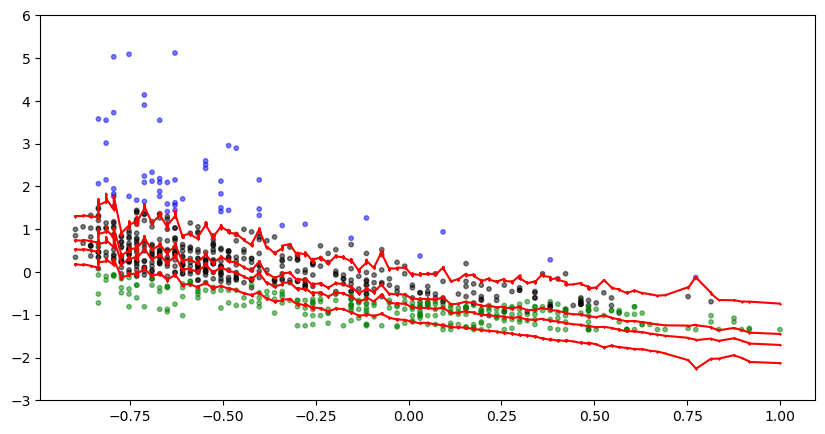

In [331]:
quantile_means = np.mean(Q_sample_collect,0)


# Extract some arrays
wanted_taus = [0.05,0.25,0.5,0.95]
tau_ids = np.array([np.where(tau_grid==w_t)[0][0] for w_t in wanted_taus])

plot_qtx = quantile_means[:, tau_ids]


fig, ax = plt.subplots(figsize=(10,5))

color_list =['black','blue','green']

ax.scatter(X_train, y_train,
            s=10, color=[color_list[i] for i in agglo_cluster_solution], alpha=0.5)

ax.plot(x_vals_arr, plot_qtx,alpha=1,lw=1.5, c='red',marker='*',ms=1)

#plt.savefig('Exp Results/Sample Output 12/mixture_QR_quantile_lines.png')
#plt.show()
ax.set_ylim([-3,6])

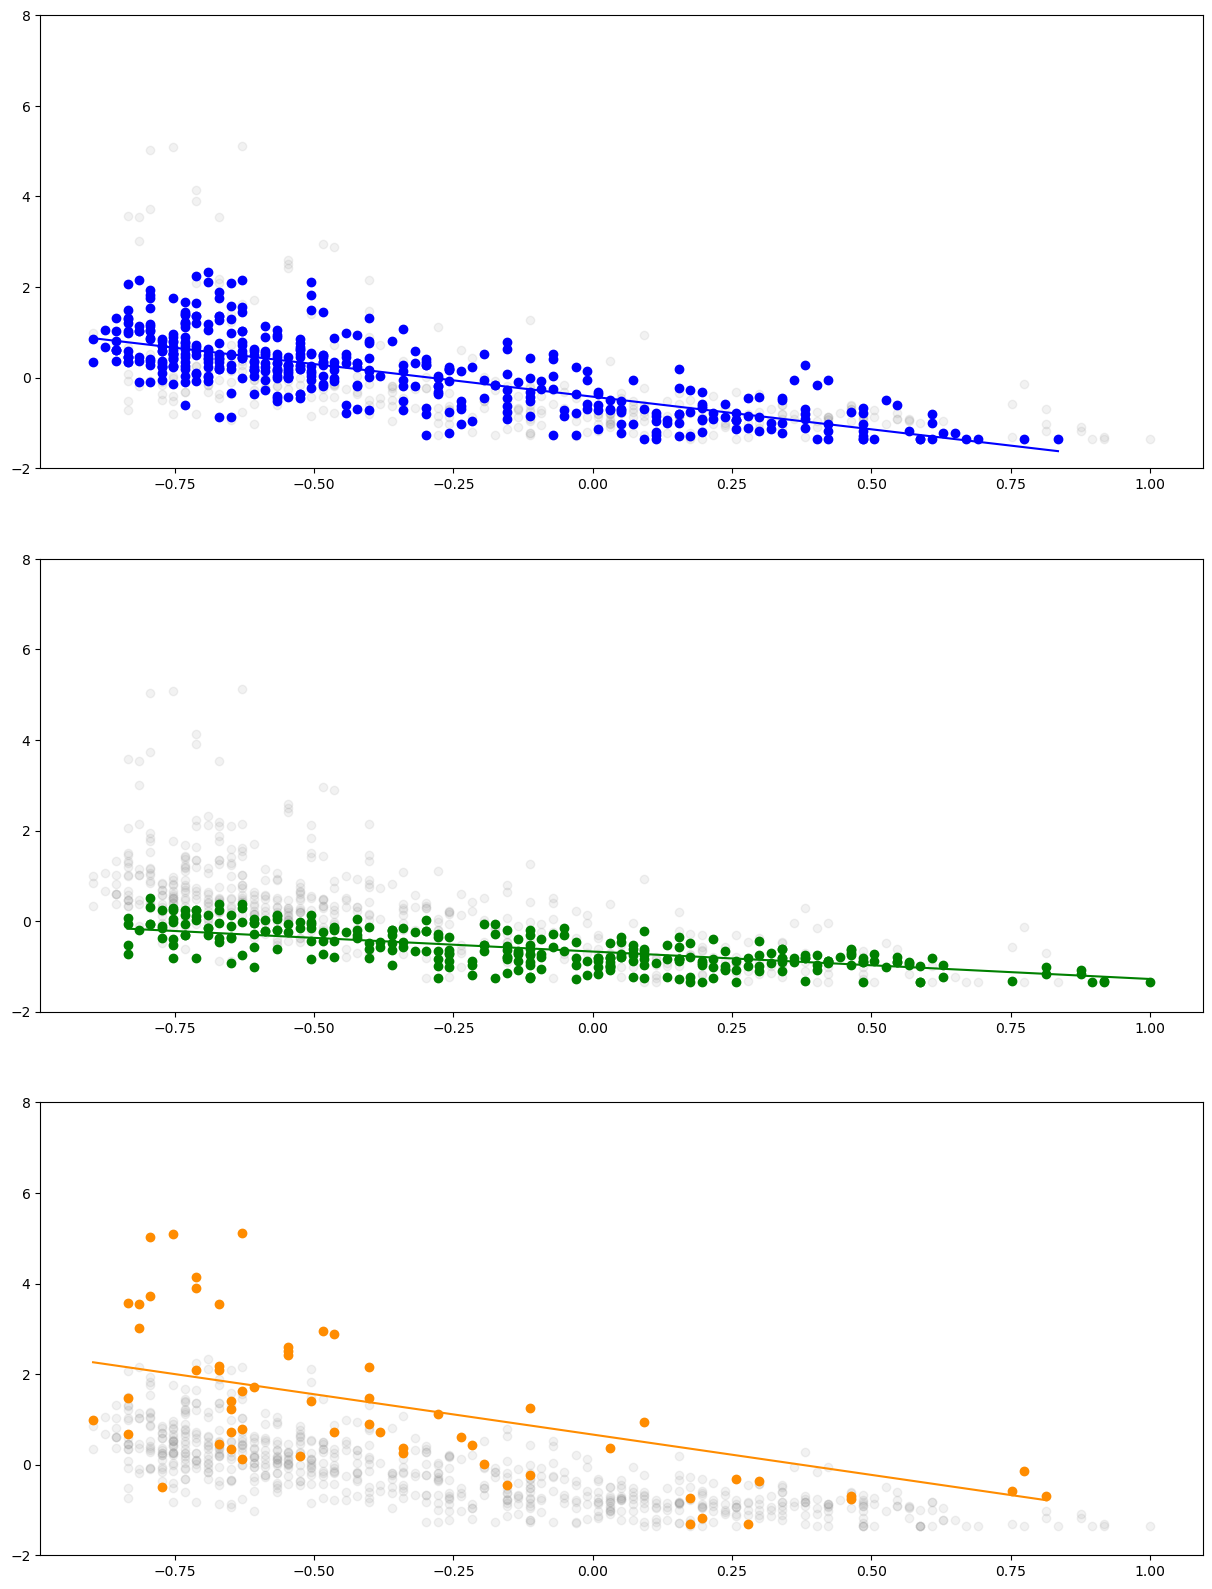

In [301]:
color_list = ['red','blue',
            'green','darkorange','black','purple','brown']

sample_quantiles = [0.5]#[0.01,0.05,0.25,0.5,0.75,0.95,0.99]#[0.05, 0.25, 0.5, 0.75, 0.95]
sample_quantile_inds = [np.argwhere(tau_grid_expanded==q)[0][0] for q in sample_quantiles]
# Split into clusters
partition_samp = partition_samp

# Get phi samp
phi_samp = phi_samp

x_vals_arr = []
output_q_tx = []
# Iterate through each cluster
n_clust = len(np.unique(partition_samp))
fig, ax = plt.subplots(n_clust,1,figsize=(n_clust*5,20))

for j,k in enumerate(np.unique(partition_samp)):

    # Extract data points + phi_k
    phi_k = phi_samp[k-1]

    point_ids = np.where(partition_samp==k)[0]

    # Extract X Values
    x_vals_k = Xs[point_ids]
    # Extract y values
    y_vals_k = Ys[point_ids]

    # Using phi generate the quantile regression function
    phi_samp_clust = phi_samp[k-1,:]
    m = (len(phi_samp_clust) - 4)// 2
    w1_knot_points_current = phi_samp_clust[0:m]
    w2_knot_points_current = phi_samp_clust[m:2*m]
    mu_current = phi_samp_clust[2*m]
    gamma_current = phi_samp_clust[2*m+1]
    #sigma_1_current = np.exp(phi_samp_clust[2*m+2])
    #sigma_2_current = np.exp(phi_samp_clust[2*m+3])
    sigma_1_current = phi_samp_clust[2*m+2]
    sigma_2_current = phi_samp_clust[2*m+3]
    # Generate quantities
    
    if prior_on_t:
        v_current = phi_samp_clust[2*m+4]

    else:
        v_current = 1.0
        
    # Generate sample of GP approx
    w1_approx_current, lp_w1_current = calc_mixture_knot_approx_marginalized(w1_knot_points_current,
                                                                            a_kappa=alpha_kappa,
                                                                            b_kappa=beta_kappa,
                                                                            tau_grid=tau_grid_expanded,
                                                                            A_g_matrices=A_matrices_G,
                                                                            cov_mat_knot_store=cov_matrices_G,
                                                                            lambda_grid_log_prob=lambda_grid_log_prob)

    w2_approx_current, lp_w2_current = calc_mixture_knot_approx_marginalized(w2_knot_points_current,
                                                                            a_kappa=alpha_kappa,
                                                                            b_kappa=beta_kappa,
                                                                            tau_grid=tau_grid_expanded,
                                                                            A_g_matrices=A_matrices_G,
                                                                            cov_mat_knot_store=cov_matrices_G,
                                                                            lambda_grid_log_prob=lambda_grid_log_prob)

    # Generate Q
    eta_1  = eta_function_i_vector(tau_input=tau_grid,
                        w_vals=w1_approx_current,
                        tau_grid=tau_grid_expanded,
                        mean=0.0,
                        sd=1.0,
                        v=v_current,
                        sigma=sigma_1_current,
                        dist=quantile_dist)

    eta_2  = eta_function_i_vector(tau_input=tau_grid,
                        w_vals=w2_approx_current,
                        tau_grid=tau_grid_expanded,
                        mean=0.0,
                        sd=1.0,
                        v=v_current,
                        sigma=sigma_2_current,
                        dist=quantile_dist)

    Q_tx  = mu_current + gamma_current * np.expand_dims(x_vals_k, -1) + \
        np.expand_dims((1-x_vals_k)/2, -1) * eta_1 + \
        np.expand_dims((1+x_vals_k)/2, -1) * eta_2
    
    beta_0_samp = mu_current + (eta_1 + eta_2)/2
    beta_1_samp = gamma_current + (eta_1 - eta_2)/2
    
    
    # Generate prediction and plot
    x_vals_arranged_k = np.sort(x_vals_k)
    y_pred_samples = np.array([b0 + b1*x_vals_arranged_k for b0,b1 in zip(beta_0_samp, beta_1_samp)])

    #ax[i].plot(X_train, y_pred_samples.mean(0), color='red')
    
    for q_id in sample_quantile_inds:
        # Extract y_preds
        y_pred_samples_plot = y_pred_samples[q_id,:]
        
        if n_clust > 1:
            ax[j].scatter(Xs, Ys, c='gray',alpha=0.1)
            ax[j].plot(x_vals_arranged_k, y_pred_samples_plot, c=color_list[j+1])
            ax[j].scatter(x_vals_k, y_vals_k, c=color_list[j+1])

            ax[j].set_ylim([-2,8])
        else:
            ax.scatter(Xs, Ys, c='gray',alpha=0.1)
            ax.plot(x_vals_arranged_k, y_pred_samples_plot, c=color_list[j+1])
            ax.scatter(x_vals_k, y_vals_k, c=color_list[j+1])

            ax.set_ylim([-2,8])

    output_q_tx.append(Q_tx)
    x_vals_arr.append(x_vals_k)

output_q_tx = np.concatenate(output_q_tx,0)
x_vals_arr = np.concatenate(x_vals_arr,0)

In [ ]:
Q_sample_collect = []
x_vals_checker = []
omitted_samps = 0
omitted_samp_id = []
omitted_samp_out = []
#bad_samps1 = np.where(np.min(np.min(Q_sample_collect,1),1)<-30)[0]
#bad_samps2 = np.where(np.min(np.min(Q_sample_collect,1),1)>30)[0]


for i in range(n_gibbs-1):#range(n_gibbs-1): # range(n_gibbs-1):
    
    #if (i in bad_samps1) or (i in bad_samps2):
     #   continue
    
    # Get cluster
    partition_samp = partition_save[i]

    # Get phi samp
    phi_samp = phi_save[i]

    output_q_tx = []
    x_vals_arr = []
    # Iterate through each cluster
    for k in np.unique(partition_samp):

        # Extract data points + phi_k
        phi_k = phi_samp[k-1]

        point_ids = np.where(partition_samp==k)[0]

        # Extract X Values
        x_vals_k = X_train[point_ids]

        # Using phi generate the quantile regression function
        phi_samp_clust = phi_samp[k-1,:]
        m = (len(phi_samp_clust) - 4)// 2
        w1_knot_points_current = phi_samp_clust[0:m]
        w2_knot_points_current = phi_samp_clust[m:2*m]
        mu_current = phi_samp_clust[2*m]
        gamma_current = phi_samp_clust[2*m+1]
        #sigma_1_current = np.exp(phi_samp_clust[2*m+2])
        #sigma_2_current = np.exp(phi_samp_clust[2*m+3])
        sigma_1_current = phi_samp_clust[2*m+2]
        sigma_2_current = phi_samp_clust[2*m+3]
        
        if prior_on_t:
            v_current = phi_samp_clust[2*m+4]
        else:
            v_current = 1.0
        # Generate quantities
        
        # Generate sample of GP approx
        w1_approx_current, lp_w1_current = calc_mixture_knot_approx_marginalized(w1_knot_points_current,
                                                                                a_kappa=alpha_kappa,
                                                                                b_kappa=beta_kappa,
                                                                                tau_grid=tau_grid_expanded,
                                                                                A_g_matrices=A_matrices_G,
                                                                                cov_mat_knot_store=cov_matrices_G,
                                                                                lambda_grid_log_prob=lambda_grid_log_prob)

        w2_approx_current, lp_w2_current = calc_mixture_knot_approx_marginalized(w2_knot_points_current,
                                                                                a_kappa=alpha_kappa,
                                                                                b_kappa=beta_kappa,
                                                                                tau_grid=tau_grid_expanded,
                                                                                A_g_matrices=A_matrices_G,
                                                                                cov_mat_knot_store=cov_matrices_G,
                                                                                lambda_grid_log_prob=lambda_grid_log_prob)
        
        # Generate Q
        eta_1  = eta_function_i_vector(tau_input=tau_grid,
                            w_vals=w1_approx_current,
                            tau_grid=tau_grid_expanded,
                            mean=0.0,
                            sd=1.0,
                            v=v_current,
                            sigma=sigma_1_current,
                            dist=quantile_dist)

        eta_2  = eta_function_i_vector(tau_input=tau_grid,
                            w_vals=w2_approx_current,
                            tau_grid=tau_grid_expanded,
                            mean=0.0,
                            sd=1.0,
                            v=v_current,
                            sigma=sigma_2_current,
                            dist=quantile_dist)
        
        Q_tx  = mu_current + gamma_current * np.expand_dims(x_vals_k, -1) + \
            np.expand_dims((1-x_vals_k)/2, -1) * eta_1 + \
            np.expand_dims((1+x_vals_k)/2, -1) * eta_2
        
        beta_0_samp = mu_current + (eta_1 + eta_2)/2
        beta_1_samp = gamma_current + (eta_1 - eta_2)/2
        
        Q_tx_alt = np.array([b0 + b1*x_vals_k for b0,b1 in zip(beta_0_samp, beta_1_samp)])
        
        output_q_tx.append(Q_tx_alt.T)
        x_vals_arr.append(x_vals_k)

    output_q_tx = np.concatenate(output_q_tx,0)
    x_vals_arr = np.concatenate(x_vals_arr,0)
    
    sort_ids = np.argsort(x_vals_arr)
    x_vals_arr = x_vals_arr[sort_ids]
    output_q_tx = output_q_tx[sort_ids,:]
    
    # Optional
    if (np.max(output_q_tx) > 1e9) or (np.min(output_q_tx)<-1e9):
        omitted_samps += 1
        omitted_samp_id.append(i)
        omitted_samp_out.append(output_q_tx)
        #continue
    
    Q_sample_collect.append(output_q_tx)
    x_vals_checker.append(x_vals_arr)

Q_sample_collect = [Q.reshape(1,len(X_train),len(tau_grid)) for Q in Q_sample_collect]
Q_sample_collect = np.concatenate(Q_sample_collect,0)

In [93]:
greek_letterz=[chr(code) for code in range(945,970)]

print(greek_letterz)


['α', 'β', 'γ', 'δ', 'ε', 'ζ', 'η', 'θ', 'ι', 'κ', 'λ', 'μ', 'ν', 'ξ', 'ο', 'π', 'ρ', 'ς', 'σ', 'τ', 'υ', 'φ', 'χ', 'ψ', 'ω']


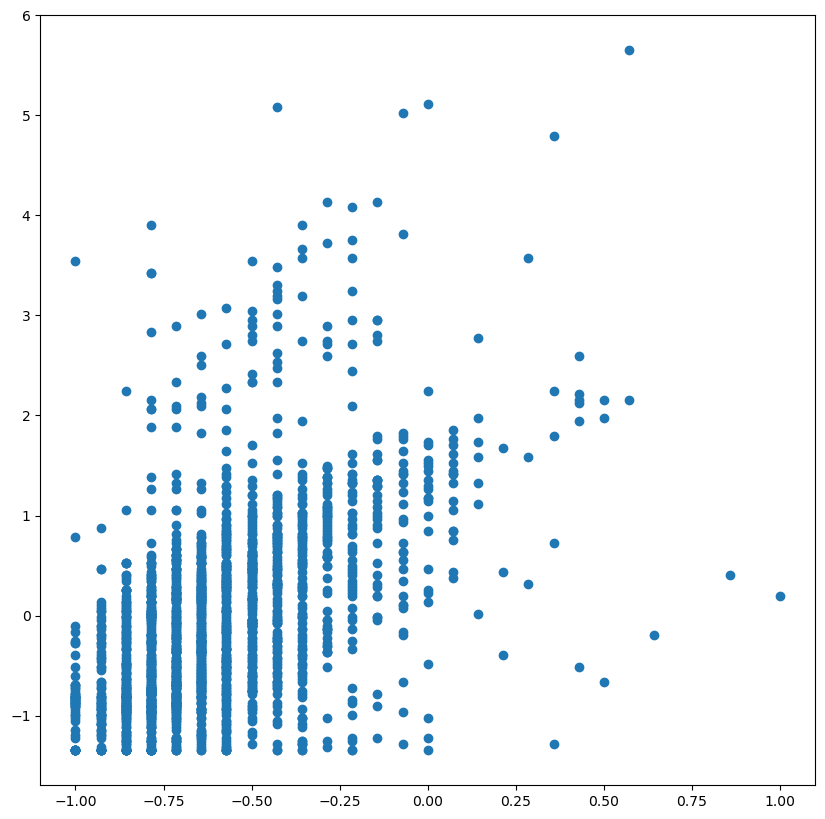

In [94]:
fig, ax = plt.subplots(figsize=(10,10))

ax.scatter(X_train, y_train)